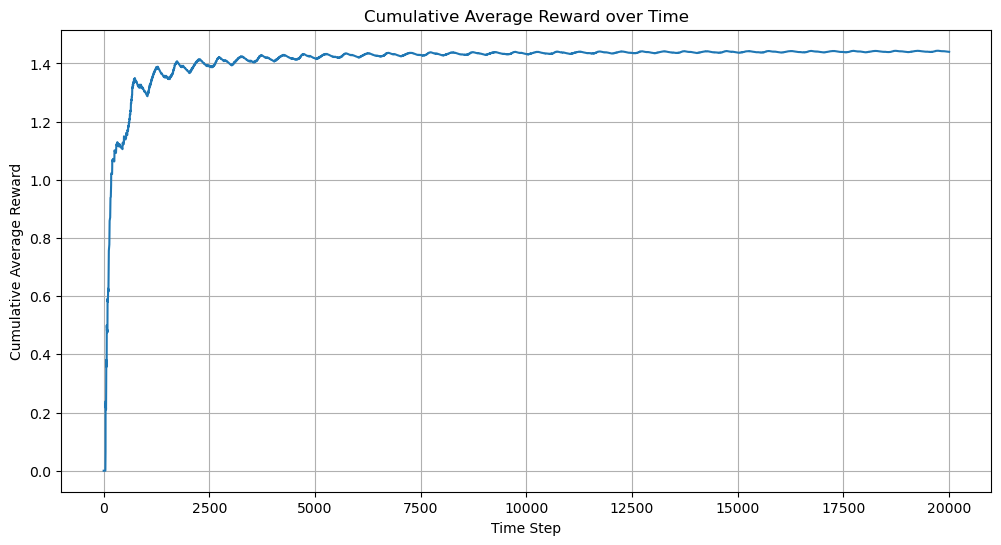

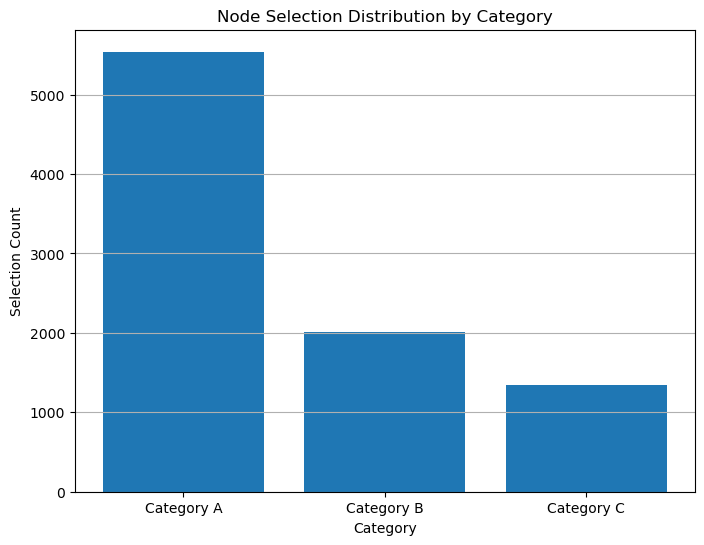

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(20000)  # Restrict to first 20000 time steps


import numpy as np
import pandas as pd

# Define the DEWMA update function
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    """
    Double Exponential Weighted Moving Average (DEWMA) filter.
    
    Parameters:
    -----------
    measured_value : float
        The current measured value
    last_state_value : float
        The previous filtered value (x1)
    last_rate_of_change : float
        The previous rate of change estimate (x2)
    delta_t : float
        Time difference between measurements
    beta_1 : float
        Smoothing factor for the value (between 0 and 1)
    beta_2 : float
        Smoothing factor for the rate of change (between 0 and 1)
    
    Returns:
    --------
    x1 : float
        Updated state value
    x2 : float
        Updated rate of change
    """
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Function to extract numeric node ID from column names dynamically
def extract_node_id(col_name):
    """
    Extract numeric node ID from column name.
    
    Parameters:
    -----------
    col_name : str
        Column name that contains node ID
        
    Returns:
    --------
    int or None
        Extracted node ID or None if no digits found
    """
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

def run_oracle_dewma_simulation(pivot_df, initial_value, theta, reward, M, beta_1=0.9, beta_2=0.01, columns=None):
    """
    Oracle policy simulation with DEWMA filtering.
    
    Parameters:
    -----------
    pivot_df : pandas.DataFrame
        DataFrame containing sensor readings over time
    initial_value : float
        Initial value for all nodes
    theta : float
        Threshold for determining eligible nodes
    reward : float
        Reward value for eligible nodes
    M : int
        Number of top nodes to select in each round
    beta_1 : float
        DEWMA smoothing factor for the value (default: 0.7)
    beta_2 : float
        DEWMA smoothing factor for the rate of change (default: 0.7)
    columns : list, optional
        List of column names representing motes/nodes. If None, all columns in pivot_df will be used
    initial_value : float
        Initial value for all nodes
    theta : float
        Threshold for determining eligible nodes
    reward : float
        Reward value for eligible nodes
    M : int
        Number of top nodes to select in each round
    beta_1 : float
        DEWMA smoothing factor for the value
    beta_2 : float
        DEWMA smoothing factor for the rate of change
        
    Returns:
    --------
    tuple
        (cumulative_rewards, valuable_sensor_df, category_counts)
    """
    # If columns is not provided, use all columns from pivot_df
    if columns is None:
        columns = pivot_df.columns.tolist()
    
    # Track the number of times each category is pulled
    category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}
    
    # Initialize last polled values and state variables for each mote
    last_polled_values = {col: initial_value for col in columns}  # Raw values
    dewma_state_values = {col: initial_value for col in columns}  # Current filtered values (x1)
    dewma_rate_values = {col: 0.0 for col in columns}  # Current rate of change values (x2)
    last_transmitted_state_values = {col: initial_value for col in columns}  # Last transmitted filtered values
    
    last_update_times = {col: 0 for col in columns}  # Initialize last update times
    cumulative_reward = 0  # Total cumulative reward
    cumulative_rewards = []  # Store cumulative average reward over time
    valuable_sensor_data = []

    for t in range(len(pivot_df)):  # Loop over each time step
        current_time_step = t
        diffs = {}

        # Calculate filtered values and differences for each mote
        for mote in columns:
            current_value = pivot_df.loc[current_time_step, mote]
            
            # Get the last state and rate values
            last_state = dewma_state_values[mote]
            last_rate = dewma_rate_values[mote]
            
            # Get the last transmitted state value for comparison
            last_transmitted_state = last_transmitted_state_values[mote]
            
            # Calculate time elapsed since last update
            delta_t = max(1, current_time_step - last_update_times[mote])
            
            # Apply DEWMA filter to get the new filtered value
            filtered_value, rate_of_change = update_node_state_dewma(
                current_value, last_state, last_rate, 1, beta_1, beta_2
            )
            
            # Update the current filtered value and rate for this node
            dewma_state_values[mote] = filtered_value
            dewma_rate_values[mote] = rate_of_change
            
            # Calculate difference between new filtered value and last transmitted value
            #diff = abs(filtered_value - last_transmitted_state)
            diff = delta_t * rate_of_change
            diffs[mote] = diff

        # Filter nodes with rewards greater than the threshold
        eligible_nodes = {mote: diff for mote, diff in diffs.items() if diff > theta}

        # Select the top M nodes among eligible nodes
        top_m_nodes = sorted(eligible_nodes, key=eligible_nodes.get, reverse=True)[:M]

        total_reward_for_round = 0

        # Process the selected nodes
        for mote in top_m_nodes:
            measured_value = pivot_df.loc[current_time_step, mote]
            
            # Get current filtered values (already calculated in the previous step)
            filtered_value = dewma_state_values[mote]
            rate_of_change = dewma_rate_values[mote]
            
            # Calculate reward
            total_reward_for_round += reward  # Reward for each selected node
            
            # Update the last transmitted state value
            last_transmitted_state_values[mote] = filtered_value
            
            # Update last polled raw value and time
            last_update_times[mote] = current_time_step
            last_polled_values[mote] = measured_value

            # Extract node ID dynamically and categorize
            node_id = extract_node_id(mote)
            if node_id is not None:
                if 1 <= node_id <= 10:
                    category_counts['Category A'] += 1
                elif 11 <= node_id <= 20:
                    category_counts['Category B'] += 1
                elif 21 <= node_id <= 30:
                    category_counts['Category C'] += 1

            # Store valuable sensor data
            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,  # Raw measured value
                'predicted_temperature': filtered_value,  # Filtered value (x1)
                'rate_of_change': rate_of_change,  # Rate of change (x2)
                'time_elapsed': current_time_step - last_update_times[mote]
            })

        # Update cumulative reward
        cumulative_reward += total_reward_for_round
        cumulative_rewards.append(cumulative_reward / (t + 1))  # Compute cumulative average reward

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)
    return cumulative_rewards, valuable_sensor_df, category_counts

# Example usage

# Setup parameters
theta = 0.3  # Threshold for eligible nodes
reward = 1.0  # Reward for each eligible node
M = 10  # Number of nodes to select per round
initial_value = 20.0  # Initial reading for all nodes

# Run simulation
cumulative_rewards, valuable_sensor_df, category_counts = run_oracle_dewma_simulation(
    pivot_df, initial_value, theta, reward, M, beta_1=0.01, beta_2=0.01
)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(cumulative_rewards)
plt.title('Cumulative Average Reward over Time')
plt.xlabel('Time Step')
plt.ylabel('Cumulative Average Reward')
plt.grid(True)
plt.show()

# Display category distribution
plt.figure(figsize=(8, 6))
categories = list(category_counts.keys())
counts = list(category_counts.values())
plt.bar(categories, counts)
plt.title('Node Selection Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Selection Count')
plt.grid(True, axis='y')
plt.show()


Transmission Count by Category:
Category A: 7459 times
Category B: 22898 times
Category C: 69376 times


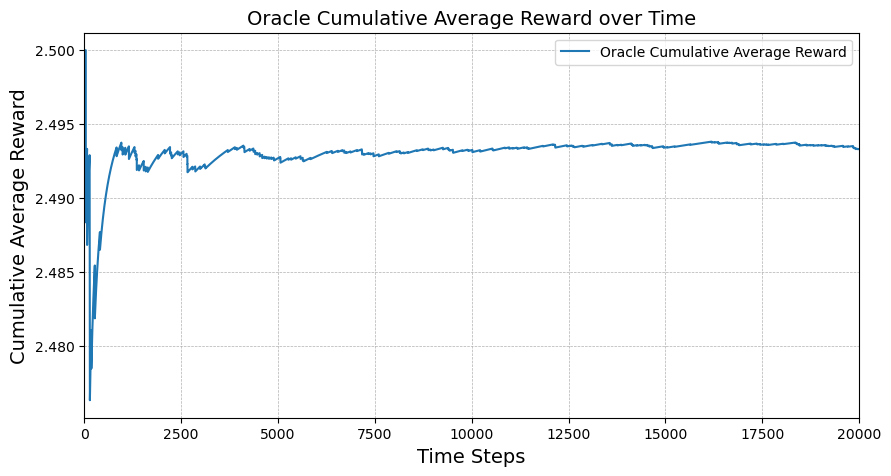

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(20000)  # Restrict to first 20000 time steps

# Parameters
reward = 0.5
M = 5  # Maximum number of nodes that can be polled
theta = 0.5  # Threshold for reward condition
penalty = -0.5  # Penalty for polling when difference is <= theta
aoii_penalty = 0.5
initial_value = 20  # Initial estimate for last polled values

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Track the number of times each category is pulled
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

# Initialize last polled values for each mote
last_polled_values = {col: initial_value for col in columns}

# Function to extract numeric node ID from column names dynamically
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Oracle policy simulation function
def run_oracle_simulation(M):
    last_update_times = {col: 0 for col in columns}  # Initialize last update times
    cumulative_reward = 0  # Total cumulative reward
    cumulative_rewards = []  # Store cumulative average reward over time
    valuable_sensor_data = []

    for t in range(len(pivot_df)):  # Loop over each time step
        current_time_step = t
        diffs = {}

        # Calculate rewards for each mote
        for mote in columns:
            current_value = pivot_df.loc[current_time_step, mote]
            last_value = last_polled_values[mote]

            # Reward is the difference between the current and last value
            diffs[mote] = abs(current_value - last_value)

        # Filter nodes with rewards greater than the threshold
        eligible_nodes = {mote: diff for mote, diff in diffs.items() if diff > theta}

        # Select the top M nodes among eligible nodes
        top_m_nodes = sorted(eligible_nodes, key=eligible_nodes.get, reverse=True)[:M]

        total_reward_for_round = 0

        # Process the selected nodes
        for mote in top_m_nodes:
            measured_value = pivot_df.loc[current_time_step, mote]
            last_value = last_polled_values[mote]

            # Calculate reward
            total_reward_for_round += reward  # Reward (since all polled nodes have value > theta)

            # Update last polled value and time
            last_update_times[mote] = current_time_step
            last_polled_values[mote] = measured_value

            # Extract node ID dynamically and categorize
            node_id = extract_node_id(mote)
            if node_id is not None:
                if 1 <= node_id <= 10:
                    category_counts['Category A'] += 1
                elif 11 <= node_id <= 20:
                    category_counts['Category B'] += 1
                elif 21 <= node_id <= 30:
                    category_counts['Category C'] += 1

            # Store valuable sensor data
            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'predicted_temperature': measured_value,  # Oracle knows the true value
                'time_elapsed': current_time_step - last_update_times[mote]
            })

        # Update cumulative reward
        cumulative_reward += total_reward_for_round
        cumulative_rewards.append(cumulative_reward / (t + 1))  # Compute cumulative average reward

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)
    return cumulative_rewards, valuable_sensor_df, category_counts

# Run the simulation for the given value of M
cumulative_rewards_oracle, valuable_sensor_df, category_pulled_counts = run_oracle_simulation(M)

# Print the number of times each category was pulled
print("Transmission Count by Category:")
for category, count in category_pulled_counts.items():
    print(f"{category}: {count} times")

# Save cumulative rewards to CSV
# Save cumulative rewards to CSV
pd.DataFrame(cumulative_rewards_oracle, columns=["cumulative_reward"]).to_csv("cumulative_rewards_oracle_final.csv", index=False)

# Save valuable sensor data to CSV
valuable_sensor_df.to_csv("valuable_sensor_data_oracle.csv", index=False)


# Plot cumulative average reward over time for Oracle
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_rewards_oracle) + 1), cumulative_rewards_oracle, label='Oracle Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Cumulative Average Reward', fontsize=14)
plt.title('Oracle Cumulative Average Reward over Time', fontsize=14)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(0, len(cumulative_rewards_oracle))

# Save the plot
plt.savefig("oracle_cumulative_average_reward_final.png")

plt.show()


Transmission Count by Category:
Category A: 33340 times
Category B: 33350 times
Category C: 33310 times


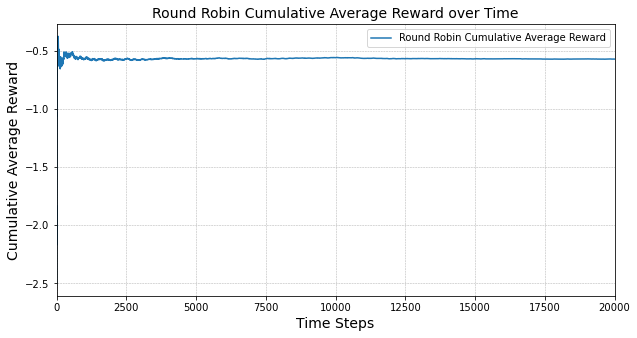

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset and preprocess
pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(20000)  # Restrict to first 20000 time steps

# Parameters
reward = 0.5
M = 5  # Maximum number of nodes that can be polled
theta = 0.5  # Threshold for significant difference
penalty = -0.5  # Penalty for insignificant difference
initial_value = 20  # Initial value for last polled
num_nodes = 30  # Total number of sensor nodes based on dataset
num_time_steps = len(pivot_df)  # Total time steps in the dataset

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]

# Track the number of times each category is pulled
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

# Initialize last polled values
last_polled_values_rr = {column: initial_value for column in columns}

# Function to extract numeric node ID from column names dynamically
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Round Robin simulation function with transmission count tracking
def run_simulation_round_robin(pivot_df, columns, M, theta, penalty):
    last_polled_values = {column: initial_value for column in columns}  # Last polled values
    cumulative_reward = 0  # Total cumulative reward
    cumulative_rewards = []  # Store cumulative rewards over time

    for t in range(len(pivot_df)):  # Loop over all time steps
        # Poll M nodes in cyclic order
        nodes_rr = [columns[(t + i) % num_nodes] for i in range(M)]  # Poll M nodes in cyclic order
        round_reward = 0  # Reward for the current time step

        for node_rr in nodes_rr:
            current_value = pivot_df.loc[t, node_rr]  # Current value for the node
            last_value = last_polled_values[node_rr]

            # Calculate reward or penalty
            if abs(current_value - last_value) > theta:
                round_reward += reward  # Reward
            else:
                round_reward += penalty  # Penalty

            # Update the last polled value
            last_polled_values[node_rr] = current_value

            # Extract node ID dynamically and categorize
            node_id = extract_node_id(node_rr)
            if node_id is not None:
                if 1 <= node_id <= 10:
                    category_counts['Category A'] += 1
                elif 11 <= node_id <= 20:
                    category_counts['Category B'] += 1
                elif 21 <= node_id <= 30:
                    category_counts['Category C'] += 1

        # Update cumulative reward
        cumulative_reward += round_reward
        cumulative_rewards.append(cumulative_reward / (t + 1))  # Append cumulative average reward

    return cumulative_rewards, category_counts

# Run Round Robin simulation with transmission count tracking
cumulative_rewards_rr, category_pulled_counts = run_simulation_round_robin(pivot_df, columns, M, theta, penalty)

# Print the number of times each category was pulled
print("Transmission Count by Category:")
for category, count in category_pulled_counts.items():
    print(f"{category}: {count} times")

# Save cumulative rewards to CSV
pd.DataFrame(cumulative_rewards_rr, columns=["cumulative_reward"]).to_csv("cumulative_rewards_round_robin_final.csv", index=False)

# Plot cumulative average reward over time
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_rewards_rr) + 1), cumulative_rewards_rr, label='Round Robin Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Cumulative Average Reward', fontsize=14)
plt.title('Round Robin Cumulative Average Reward over Time', fontsize=14)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(0, len(cumulative_rewards_rr))

# Save the plot
plt.savefig("round_robin_cumulative_average_reward_final.png")

plt.show()


Transmission Count by Category:
Category A: 33340 times
Category B: 33330 times
Category C: 33330 times


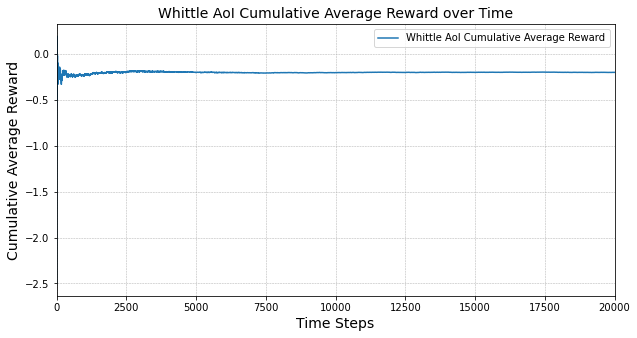

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset and preprocess
pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(20000)  # Restrict to first 20000 time steps

# Parameters
reward = 0.5
M = 5  # Number of nodes to poll
theta = 0.5  # Threshold for node transmission
penalty = -0.5  # Penalty for polling when the condition is not met
num_nodes = len([col for col in pivot_df.columns if col != "SN"])  # Total number of sensor nodes
num_time_steps = len(pivot_df)  # Total time steps in the dataset

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]

# Track the number of times each category is pulled
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

# Initialize last polled values
last_polled_values_whittle = {col: 20.0 for col in columns}  # Initial values

# Function to extract numeric node ID from column names dynamically
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Whittle Index-based AoI simulation function with transmission count tracking
def run_simulation_whittle_aoi(pivot_df, num_nodes, M, theta, penalty):
    """Simulate Whittle Index-based polling strategy for AoI with transmission count tracking."""
    cumulative_reward = 0
    cumulative_rewards = []
    last_update_whittle = np.zeros(num_nodes)  # Track last update times
    last_polled_values = {col: 20.0 for col in pivot_df.columns}  # Initialize last polled values

    for t in range(len(pivot_df)):  # Iterate over all time steps
        whittle_indices = {}

        # Compute Whittle indices for each node
        for node in range(num_nodes):  # Now using 0-based index
            column_name = pivot_df.columns[node]  # Get column directly
            
            delta_t_dynamic = t - last_update_whittle[node]  # Time since last update
            current_aoi = delta_t_dynamic
            future_aoi_passive = delta_t_dynamic + penalty
            future_aoi_active = 0  # Assuming perfect transmission

            q_passive = current_aoi + future_aoi_passive
            q_active = current_aoi + future_aoi_active + penalty  # No additional penalty for active action
            whittle_indices[node] = q_passive - q_active

        # Step 2: Select top M nodes
        nodes_to_poll = [node for node, index in whittle_indices.items() if index >= 0]
        if len(nodes_to_poll) > M:
            nodes_to_poll = sorted(nodes_to_poll, key=lambda node: whittle_indices[node], reverse=True)[:M]

        round_reward = 0  # Reward for the current time step

        # Step 3: Poll selected nodes
        for node in nodes_to_poll:
            column_name = pivot_df.columns[node]  # Get the column name
            
            current_value = pivot_df.loc[t, column_name]
            last_value = last_polled_values[column_name]

            # Calculate reward or penalty
            if abs(current_value - last_value) > theta:
                round_reward += reward  # Reward
            else:
                round_reward += penalty  # Penalty

            # Update last polled values
            last_polled_values[column_name] = current_value
            last_update_whittle[node] = t  # Update last update time

            # Extract node ID dynamically and categorize
            node_id = extract_node_id(column_name)
            if node_id is not None:
                if 1 <= node_id <= 10:
                    category_counts['Category A'] += 1
                elif 11 <= node_id <= 20:
                    category_counts['Category B'] += 1
                elif 21 <= node_id <= 30:
                    category_counts['Category C'] += 1

        # Update cumulative reward
        cumulative_reward += round_reward
        cumulative_rewards.append(cumulative_reward / (t + 1))  # Compute cumulative average reward

    return cumulative_rewards, category_counts

# Run the simulation with transmission count tracking
cumulative_rewards_whittle, category_pulled_counts = run_simulation_whittle_aoi(pivot_df, num_nodes, M, theta, penalty)

# Print the number of times each category was pulled
print("Transmission Count by Category:")
for category, count in category_pulled_counts.items():
    print(f"{category}: {count} times")

# Save cumulative rewards to CSV
pd.DataFrame(cumulative_rewards_whittle, columns=["cumulative_reward"]).to_csv("cumulative_rewards_whittle_aoi_final.csv", index=False)

# Plot cumulative average reward over time
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_rewards_whittle) + 1), cumulative_rewards_whittle, label='Whittle AoI Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Cumulative Average Reward', fontsize=14)
plt.title('Whittle AoI Cumulative Average Reward over Time', fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.xlim(0, len(cumulative_rewards_whittle))

# Save the plot
plt.savefig("whittle_aoi_cumulative_average_reward_final.png")
plt.show()


Transmission Count by Category:
Category A: 22245 times
Category B: 26397 times
Category C: 43643 times


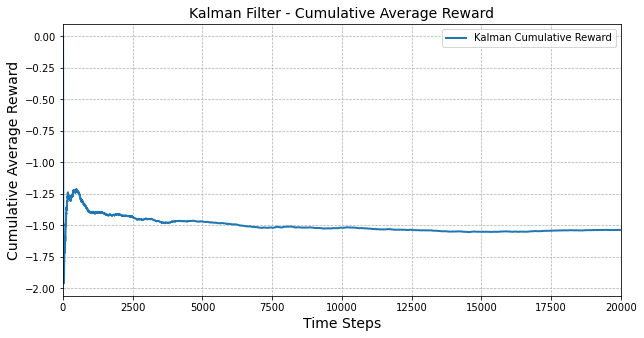

Final Cumulative Average Reward: -1.5351


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load dataset and preprocess
pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(20000)  # Restrict to first 20000 time steps

# Parameters
reward = 0.5
M = 5  # Number of nodes to poll at each time step
theta = 0.5  # Threshold for node transmission
penalty = -0.5  # Penalty when the condition is not met
num_nodes = 30  # Total number of nodes in the dataset

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]

# Track the number of times each category is polled
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

# Initialize state vectors and covariance matrices
x_hat_node = {col: np.array([20.0, 0.1]) for col in columns}
P_node = {col: np.eye(2) for col in columns}
x_hat_sink = {col: np.array([20.0, 0.1]) for col in columns}

# Track last update times
last_update_times = {col: 0 for col in columns}

# Kalman filter matrices
A_node = np.array([[1, 1],  # State transition matrix
                   [0, 1]])
Q_node = np.array([[0.01, 0],  # Process noise covariance
                   [0, 0.01]])
H_node = np.array([[1, 0]])  # Observation matrix
R = np.array([[0.1]])  # Measurement noise covariance

# Function to extract numeric node ID from column names dynamically
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Kalman filter function for nodes
def kalman_node(measured_value, x_hat, P):
    xp = A_node @ x_hat
    Pp = A_node @ P @ A_node.T + Q_node
    K = Pp @ H_node.T @ np.linalg.inv(H_node @ Pp @ H_node.T + R)
    x_hat = xp + K @ (measured_value - H_node @ xp)
    P = Pp - K @ H_node @ Pp
    return x_hat, P

# Predict node state from sink
def predict_node_state_from_sink(x_hat, delta_t_dynamic):
    predicted_value = x_hat[0] + x_hat[1] * delta_t_dynamic
    return np.array([predicted_value, x_hat[1]])

# Polling function with transmission count tracking
def poll_nodes(pivot_df, current_time, x_hat_node, x_hat_sink, P_node, M, cumulative_reward):
    exceedance_values = {}

    # Step 1: Predict sink values and check if threshold is exceeded
    for column_name in columns:
        last_update_time = last_update_times[column_name]
        delta_t_dynamic = current_time + 1 - last_update_time

        predicted_value = predict_node_state_from_sink(x_hat_sink[column_name], delta_t_dynamic)[0]
        if abs(predicted_value - x_hat_sink[column_name][0]) > theta:
            exceedance_values[column_name] = abs(predicted_value - x_hat_sink[column_name][0])

    # Step 2: Select top M nodes
    nodes_to_poll = sorted(exceedance_values, key=exceedance_values.get, reverse=True)[:M]

    # Step 3: Poll selected nodes
    for column_name in nodes_to_poll:
        measured_value = pivot_df.loc[current_time, column_name]

        # Node Kalman filtering
        x_hat_node[column_name], P_node[column_name] = kalman_node(measured_value, x_hat_node[column_name], P_node[column_name])
        x_hat_sink[column_name] = x_hat_node[column_name]  # Update sink state

        last_update_times[column_name] = current_time

        # Step 4: Compute reward
        if abs(measured_value - x_hat_sink[column_name][0]) > theta:
            cumulative_reward += reward  # Reward
        else:
            cumulative_reward += penalty  # Penalty

        # Extract node ID dynamically and categorize
        node_id = extract_node_id(column_name)
        if node_id is not None:
            if 1 <= node_id <= 10:
                category_counts['Category A'] += 1
            elif 11 <= node_id <= 20:
                category_counts['Category B'] += 1
            elif 21 <= node_id <= 30:
                category_counts['Category C'] += 1

    return x_hat_node, x_hat_sink, P_node, cumulative_reward

# Initialize cumulative reward tracking
cumulative_reward = 0  # Single cumulative reward for all nodes
cumulative_rewards_over_time = []  # To track cumulative average reward over time

# Simulation settings
num_steps = len(pivot_df)

# Run the simulation
for t in range(num_steps):
    x_hat_node, x_hat_sink, P_node, cumulative_reward = poll_nodes(
        pivot_df, t, x_hat_node, x_hat_sink, P_node, M, cumulative_reward
    )
    
    # Compute cumulative average reward
    avg_reward = cumulative_reward / (t + 1)
    cumulative_rewards_over_time.append(avg_reward)

# Print the number of times each category was pulled
print("Transmission Count by Category:")
for category, count in category_counts.items():
    print(f"{category}: {count} times")

# Save cumulative rewards to CSV
pd.DataFrame(cumulative_rewards_over_time, columns=["cumulative_reward"]).to_csv("cumulative_rewards_kalman_final.csv", index=False)

# Plot cumulative average reward
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_rewards_over_time) + 1), cumulative_rewards_over_time, label='Kalman Cumulative Reward', linewidth=2)
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Cumulative Average Reward", fontsize=14)
plt.title("Kalman Filter - Cumulative Average Reward", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.xlim(0, len(cumulative_rewards_over_time))

# Save the plot
plt.savefig("kalman_cumulative_average_reward_final.png")
plt.show()

# Print final cumulative reward statistics
print(f"Final Cumulative Average Reward: {cumulative_rewards_over_time[-1]:.4f}")


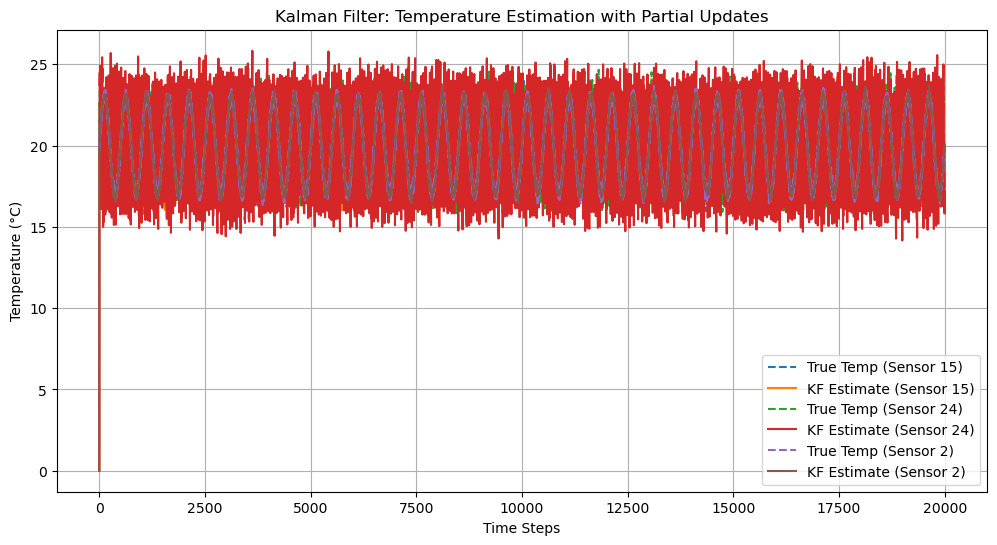


Final Average MSE: 0.942429

Final counts of how many times each category was polled:
{'Category A': 32216, 'Category B': 32300, 'Category C': 32266}


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load dataset and preprocess
pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(20000)  # Restrict to first 20000 time steps

# Define parameters
num_sensors = pivot_df.shape[1]  # Number of sensors
time_steps = pivot_df.shape[0]  # Number of time steps
M = 5  # Number of sensors to poll at each time step

# Kalman Filter Parameters
dt = 1  # Time step
A = np.array([[1, dt], [0, 1]])  # State transition matrix
H = np.array([[1, 0]])  # Observation matrix (we only measure temperature)
Q = np.array([[1e-3, 0], [0, 1e-3]])  # Process noise covariance
R = np.array([[0.5]])  # Measurement noise covariance

# Initialize Kalman Filter states (temperature & rate of change)
X = np.zeros((num_sensors, 2, 1))  # Initial state for each sensor
X[:, 0, 0] = pivot_df.iloc[0, :].values  # Initialize temperature estimates
X[:, 1, 0] = 0  # Assume initial rate of change is zero

# Initial estimate uncertainty (P matrix)
P = np.array([np.eye(2) for _ in range(num_sensors)])  # Covariance per sensor

# Initialize category count tracker
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

# Function to extract node ID from column name
def extract_node_id(column_name):
    try:
        return int(''.join(filter(str.isdigit, column_name)))  # Extract numeric part
    except ValueError:
        return None  # In case of invalid format

# Store estimated temperatures & MSE tracking
estimated_temperatures = np.zeros((time_steps, num_sensors))
mse_list = []

# Kalman filter loop
for t in range(1, time_steps):
    # Step 1: Prediction (for all sensors)
    for i in range(num_sensors):
        X[i] = A @ X[i]  # Predict next state
        P[i] = A @ P[i] @ A.T + Q  # Predict next covariance

    # Step 2: Select M sensors to poll (based on largest covariance trace)
    covariance_traces = np.array([np.trace(P[i]) for i in range(num_sensors)])
    polled_indices = np.argsort(covariance_traces)[-M:]  # Select M sensors with highest uncertainty

    # Step 3: Update step (only for polled sensors)
    for i in polled_indices:
        Z = np.array([[pivot_df.iloc[t, i]]])  # Measurement for this sensor
        y = Z - (H @ X[i])  # Measurement residual
        S = H @ P[i] @ H.T + R  # Residual covariance
        K = P[i] @ H.T @ np.linalg.inv(S)  # Kalman Gain
        X[i] = X[i] + K @ y  # Update estimate
        P[i] = (np.eye(2) - K @ H) @ P[i]  # Update covariance

        # Step 4: Categorize polled sensors
        node_id = extract_node_id(pivot_df.columns[i])
        if node_id is not None:
            if 1 <= node_id <= 10:
                category_counts['Category A'] += 1
            elif 11 <= node_id <= 20:
                category_counts['Category B'] += 1
            elif 21 <= node_id <= 30:
                category_counts['Category C'] += 1

    # Store estimates
    estimated_temperatures[t, :] = X[:, 0, 0]

    # Compute MSE for this time step
    mse_list.append(mean_squared_error(pivot_df.iloc[t, :], estimated_temperatures[t, :]))

# Compute final average MSE
average_mse = np.mean(mse_list)

# Plot results for a few random sensors
plt.figure(figsize=(12, 6))
for i in np.random.choice(num_sensors, 3, replace=False):  # Plot 3 random sensors
    plt.plot(pivot_df.iloc[:, i], label=f"True Temp (Sensor {i})", linestyle="dashed")
    plt.plot(estimated_temperatures[:, i], label=f"KF Estimate (Sensor {i})")

plt.xlabel("Time Steps")
plt.ylabel("Temperature (°C)")
plt.title("Kalman Filter: Temperature Estimation with Partial Updates")
plt.legend()
plt.grid()
plt.show()

# Display final MSE and category polling counts
print(f"\nFinal Average MSE: {average_mse:.6f}")
print(f"\nFinal counts of how many times each category was polled:")
print(category_counts)


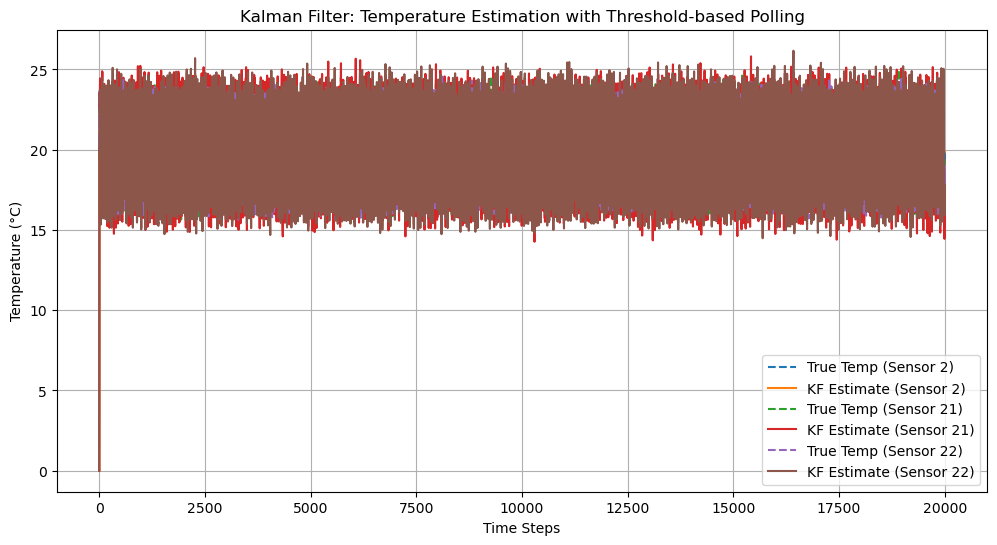


Final Average MSE: 4300969.061937

Final counts of how many times each category was polled:
{'Category A': 26923, 'Category B': 38460, 'Category C': 34612}

Sensors polled at last time step: [25, 23, 13, 7, 17]


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load dataset and preprocess
pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(20000)  # Restrict to first 20000 time steps

# Define parameters
num_sensors = pivot_df.shape[1]  # Number of sensors
time_steps = pivot_df.shape[0]  # Number of time steps
M = 5  # Number of sensors to poll at each time step
theta = 0.5  # Threshold for polling based on rate of change

# Kalman Filter Parameters
dt = 1  # Time step
A = np.array([[1, dt], [0, 1]])  # State transition matrix
H = np.array([[1, 0]])  # Observation matrix (we only measure temperature)
Q = np.array([[1e-3, 0], [0, 1e-3]])  # Process noise covariance
R = np.array([[0.5]])  # Measurement noise covariance

# Initialize Kalman Filter states (temperature & rate of change)
X = np.zeros((num_sensors, 2, 1))  # Initial state for each sensor
X[:, 0, 0] = pivot_df.iloc[0, :].values  # Initialize temperature estimates
X[:, 1, 0] = 0  # Assume initial rate of change is zero

# Initial estimate uncertainty (P matrix)
P = np.array([np.eye(2) for _ in range(num_sensors)])  # Covariance per sensor

# Initialize last update times for all sensors
last_update_times = np.zeros(num_sensors)

# Initialize category count tracker
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

# Function to extract node ID from column name
def extract_node_id(column_name):
    try:
        return int(''.join(filter(str.isdigit, column_name)))  # Extract numeric part
    except ValueError:
        return None  # In case of invalid format

# Store estimated temperatures & MSE tracking
estimated_temperatures = np.zeros((time_steps, num_sensors))
mse_list = []

# Kalman filter loop
for t in range(1, time_steps):
    # Step 1: Prediction (for all sensors)
    for i in range(num_sensors):
        X[i] = A @ X[i]  # Predict next state
        P[i] = A @ P[i] @ A.T + Q  # Predict next covariance

    # Step 2: Select M sensors based on highest covariance trace
    covariance_traces = np.array([np.trace(P[i]) for i in range(num_sensors)])
    candidate_indices = np.argsort(covariance_traces)[-2 * M:]  # Select top 2M nodes initially

    polled_indices = []
    for i in candidate_indices:
        rate_of_change = abs(X[i, 1, 0])  # Estimated rate of change
        time_since_last_update = t - last_update_times[i]

        # Step 3: Check threshold condition before including in polled nodes
        if time_since_last_update * rate_of_change > theta:
            polled_indices.append(i)
            if len(polled_indices) == M:  # Stop once we have M valid nodes
                break

    # Step 4: If we couldn't find enough nodes passing the threshold, backfill with the next highest covariance nodes
    if len(polled_indices) < M:
        additional_needed = M - len(polled_indices)
        remaining_candidates = [i for i in candidate_indices if i not in polled_indices]
        polled_indices.extend(remaining_candidates[:additional_needed])

    # Step 5: Update step (only for polled sensors)
    for i in polled_indices:
        Z = np.array([[pivot_df.iloc[t, i]]])  # Measurement for this sensor
        y = Z - (H @ X[i])  # Measurement residual
        S = H @ P[i] @ H.T + R  # Residual covariance
        K = P[i] @ H.T @ np.linalg.inv(S)  # Kalman Gain
        X[i] = X[i] + K @ y  # Update estimate
        P[i] = (np.eye(2) - K @ H) @ P[i]  # Update covariance
        last_update_times[i] = t  # Update last polled time

        # Step 6: Categorize polled sensors
        node_id = extract_node_id(pivot_df.columns[i])
        if node_id is not None:
            if 1 <= node_id <= 10:
                category_counts['Category A'] += 1
            elif 11 <= node_id <= 20:
                category_counts['Category B'] += 1
            elif 21 <= node_id <= 30:
                category_counts['Category C'] += 1

    # Store estimates
    estimated_temperatures[t, :] = X[:, 0, 0]

    # Compute MSE for this time step
    mse_list.append(mean_squared_error(pivot_df.iloc[t, :], estimated_temperatures[t, :]))

# Compute final average MSE
average_mse = np.mean(mse_list)

# Plot results for a few random sensors
plt.figure(figsize=(12, 6))
for i in np.random.choice(num_sensors, 3, replace=False):  # Plot 3 random sensors
    plt.plot(pivot_df.iloc[:, i], label=f"True Temp (Sensor {i})", linestyle="dashed")
    plt.plot(estimated_temperatures[:, i], label=f"KF Estimate (Sensor {i})")

plt.xlabel("Time Steps")
plt.ylabel("Temperature (°C)")
plt.title("Kalman Filter: Temperature Estimation with Threshold-based Polling")
plt.legend()
plt.grid()
plt.show()

# Display final MSE and category polling counts
print(f"\nFinal Average MSE: {average_mse:.6f}")
print(f"\nFinal counts of how many times each category was polled:")
print(category_counts)
print(f"\nSensors polled at last time step: {polled_indices}")


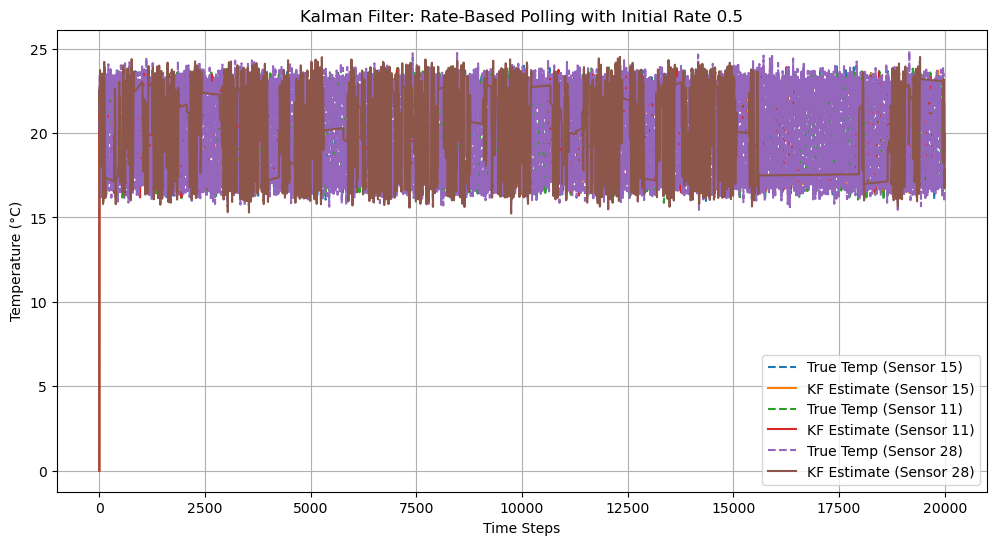


Final Average MSE: 5.957947

Final counts of how many times each category was polled:
{'Category A': 8792, 'Category B': 22248, 'Category C': 48961}

Sensors polled at last time step: [14  9 12 24 30]


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load dataset and preprocess
pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(20000)  # Restrict to first 20000 time steps

# Define parameters
num_sensors = pivot_df.shape[1]  # Number of sensors
time_steps = pivot_df.shape[0]  # Number of time steps
M = 5  # Number of sensors to poll at each time step
initial_rate = 0.5  # Initial rate of change to ensure early polling

# Kalman Filter Parameters
dt = 1  # Time step
A = np.array([[1, dt], [0, 1]])  # State transition matrix
H = np.array([[1, 0]])  # Observation matrix (we only measure temperature)
Q = np.array([[1e-3, 0], [0, 1e-3]])  # Process noise covariance
R = np.array([[0.5]])  # Measurement noise covariance

# Initialize Kalman Filter states (temperature & rate of change)
X = np.zeros((num_sensors, 2, 1))  # Initial state for each sensor
X[:, 0, 0] = pivot_df.iloc[0, :].values  # Initialize temperature estimates
X[:, 1, 0] = initial_rate  # Initialize rate of change with nonzero value

# Initial estimate uncertainty (P matrix)
P = np.array([np.eye(2) for _ in range(num_sensors)])  # Covariance per sensor

# Initialize last update times for all sensors
last_update_times = np.zeros(num_sensors)

# Initialize category count tracker
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

# Function to extract node ID from column name
def extract_node_id(column_name):
    try:
        return int(''.join(filter(str.isdigit, column_name)))  # Extract numeric part
    except ValueError:
        return None  # In case of invalid format

# Store estimated temperatures & MSE tracking
estimated_temperatures = np.zeros((time_steps, num_sensors))
mse_list = []

# Kalman filter loop
for t in range(1, time_steps):
    # Step 1: Prediction (for all sensors)
    for i in range(num_sensors):
        X[i] = A @ X[i]  # Predict next state
        P[i] = A @ P[i] @ A.T + Q  # Predict next covariance

    # Step 2: Compute polling scores based on rate of change * time elapsed
    polling_scores = np.array([(t - last_update_times[i]) * abs(X[i, 1, 0]) for i in range(num_sensors)])
    polled_indices = np.argsort(polling_scores)[-M:]  # Select M nodes with highest score

    # Step 3: Update step (only for polled sensors)
    for i in polled_indices:
        Z = np.array([[pivot_df.iloc[t, i]]])  # Measurement for this sensor
        y = Z - (H @ X[i])  # Measurement residual
        S = H @ P[i] @ H.T + R  # Residual covariance
        K = P[i] @ H.T @ np.linalg.inv(S)  # Kalman Gain
        X[i] = X[i] + K @ y  # Update estimate
        P[i] = (np.eye(2) - K @ H) @ P[i]  # Update covariance
        last_update_times[i] = t  # Reset last update time for this node

        # Step 4: Categorize polled sensors
        node_id = extract_node_id(pivot_df.columns[i])
        if node_id is not None:
            if 1 <= node_id <= 10:
                category_counts['Category A'] += 1
            elif 11 <= node_id <= 20:
                category_counts['Category B'] += 1
            elif 21 <= node_id <= 30:
                category_counts['Category C'] += 1

    # Store estimates
    estimated_temperatures[t, :] = X[:, 0, 0]

    # Compute MSE for this time step
    mse_list.append(mean_squared_error(pivot_df.iloc[t, :], estimated_temperatures[t, :]))

# Compute final average MSE
average_mse = np.mean(mse_list)

# Plot results for a few random sensors
plt.figure(figsize=(12, 6))
for i in np.random.choice(num_sensors, 3, replace=False):  # Plot 3 random sensors
    plt.plot(pivot_df.iloc[:, i], label=f"True Temp (Sensor {i})", linestyle="dashed")
    plt.plot(estimated_temperatures[:, i], label=f"KF Estimate (Sensor {i})")

plt.xlabel("Time Steps")
plt.ylabel("Temperature (°C)")
plt.title("Kalman Filter: Rate-Based Polling with Initial Rate 0.5")
plt.legend()
plt.grid()
plt.show()

# Display final MSE and category polling counts
print(f"\nFinal Average MSE: {average_mse:.6f}")
print(f"\nFinal counts of how many times each category was polled:")
print(category_counts)
print(f"\nSensors polled at last time step: {polled_indices}")



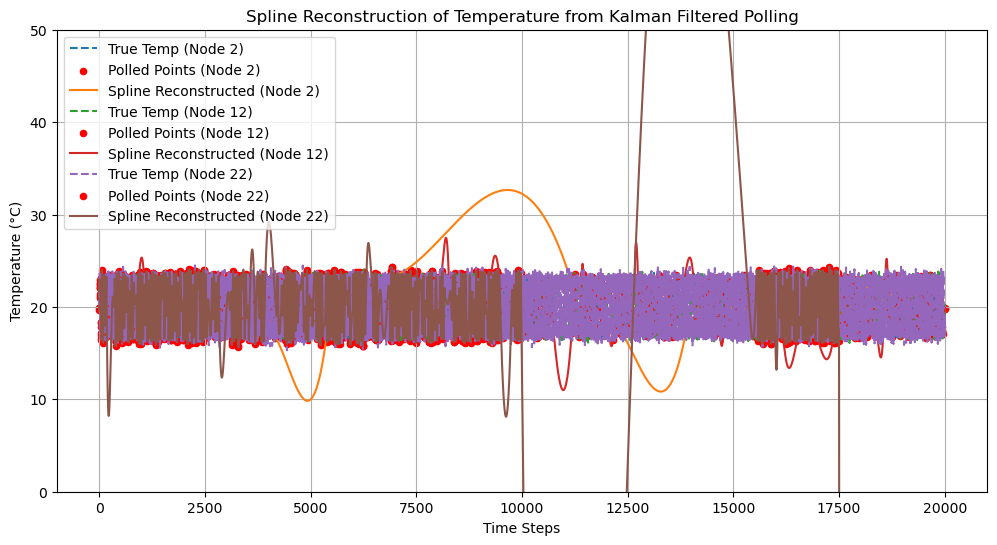


Final Average MSE: 5.957947


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from sklearn.metrics import mean_squared_error

# Load dataset and preprocess
pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(20000)  # Restrict to first 20000 time steps

# Define parameters
num_sensors = pivot_df.shape[1]  # Number of sensors
time_steps = pivot_df.shape[0]  # Number of time steps
M = 5  # Number of sensors to poll at each time step
initial_rate = 0.5  # Initial rate of change to ensure early polling

# Kalman Filter Parameters
dt = 1  # Time step
A = np.array([[1, dt], [0, 1]])  # State transition matrix
H = np.array([[1, 0]])  # Observation matrix (we only measure temperature)
Q = np.array([[1e-3, 0], [0, 1e-3]])  # Process noise covariance
R = np.array([[0.5]])  # Measurement noise covariance

# Initialize Kalman Filter states (temperature & rate of change)
X = np.zeros((num_sensors, 2, 1))  # Initial state for each sensor
X[:, 0, 0] = pivot_df.iloc[0, :].values  # Initialize temperature estimates
X[:, 1, 0] = initial_rate  # Initialize rate of change with nonzero value

# Initial estimate uncertainty (P matrix)
P = np.array([np.eye(2) for _ in range(num_sensors)])  # Covariance per sensor

# Initialize last update times for all sensors
last_update_times = np.zeros(num_sensors)

# Track polled nodes per category
polled_timestamps = {cat: [] for cat in ['A', 'B', 'C']}
polled_temps = {cat: [] for cat in ['A', 'B', 'C']}
polled_rates = {cat: [] for cat in ['A', 'B', 'C']}
sample_nodes = {'A': 2, 'B': 12, 'C': 22}  # Sample nodes for each category

# Store estimated temperatures & MSE tracking
estimated_temperatures = np.zeros((time_steps, num_sensors))
mse_list = []

# Kalman filter loop
for t in range(1, time_steps):
    # Step 1: Prediction (for all sensors)
    for i in range(num_sensors):
        X[i] = A @ X[i]  # Predict next state
        P[i] = A @ P[i] @ A.T + Q  # Predict next covariance

    # Step 2: Compute polling scores based on rate of change * time elapsed
    polling_scores = np.array([(t - last_update_times[i]) * abs(X[i, 1, 0]) for i in range(num_sensors)])
    polled_indices = np.argsort(polling_scores)[-M:]  # Select M nodes with highest score

    # Step 3: Update step (only for polled sensors)
    for i in polled_indices:
        Z = np.array([[pivot_df.iloc[t, i]]])  # Measurement for this sensor
        y = Z - (H @ X[i])  # Measurement residual
        S = H @ P[i] @ H.T + R  # Residual covariance
        K = P[i] @ H.T @ np.linalg.inv(S)  # Kalman Gain
        X[i] = X[i] + K @ y  # Update estimate
        P[i] = (np.eye(2) - K @ H) @ P[i]  # Update covariance
        last_update_times[i] = t  # Reset last update time for this node

        # If this node belongs to our sampled nodes, track its updates
        for category, node_id in sample_nodes.items():
            if i == node_id:
                polled_timestamps[category].append(t)
                polled_temps[category].append(X[i, 0, 0])  # Estimated temperature
                polled_rates[category].append(X[i, 1, 0])  # Estimated rate of change

    # Store estimates
    estimated_temperatures[t, :] = X[:, 0, 0]

    # Compute MSE for this time step
    mse_list.append(mean_squared_error(pivot_df.iloc[t, :], estimated_temperatures[t, :]))

# Compute final average MSE
average_mse = np.mean(mse_list)

# Function to perform spline reconstruction
def reconstruct_spline(time_points, values, rates, full_time):
    if len(time_points) < 3:
        return np.interp(full_time, time_points, values)  # Linear interpolation if too few points

    # Use cubic spline with derivatives (rate of change as constraint)
    cs = CubicSpline(time_points, values, bc_type=((1, rates[0]), (1, rates[-1])))
    return cs(full_time)

# Generate reconstructed curves for each category
full_time = np.arange(time_steps)
reconstructed_values = {cat: reconstruct_spline(polled_timestamps[cat], polled_temps[cat], polled_rates[cat], full_time)
                        for cat in sample_nodes.keys()}

# Plot results for each sample node
plt.figure(figsize=(12, 6))
for category, node_id in sample_nodes.items():
    plt.plot(full_time, pivot_df.iloc[:, node_id], label=f"True Temp (Node {node_id})", linestyle="dashed")
    plt.scatter(polled_timestamps[category], polled_temps[category], label=f"Polled Points (Node {node_id})", color="red", s=20)
    plt.plot(full_time, reconstructed_values[category], label=f"Spline Reconstructed (Node {node_id})")

plt.xlabel("Time Steps")
plt.ylabel("Temperature (°C)")
plt.title("Spline Reconstruction of Temperature from Kalman Filtered Polling")
plt.legend()
plt.ylim(0,50)
plt.grid()
plt.show()

# Display final MSE
print(f"\nFinal Average MSE: {average_mse:.6f}")



Category A (Sensor 0):
Number of polling points: 2694
Cubic Spline MSE: 12.308153
Kalman Filter MSE: 3.364858
Improvement: -265.79%

Category B (Sensor 10):
Number of polling points: 2530
Cubic Spline MSE: 5701.557082
Kalman Filter MSE: 4.061147
Improvement: -140292.77%

Category C (Sensor 20):
Number of polling points: 3866
Cubic Spline MSE: 32.800073
Kalman Filter MSE: 3.240591
Improvement: -912.16%


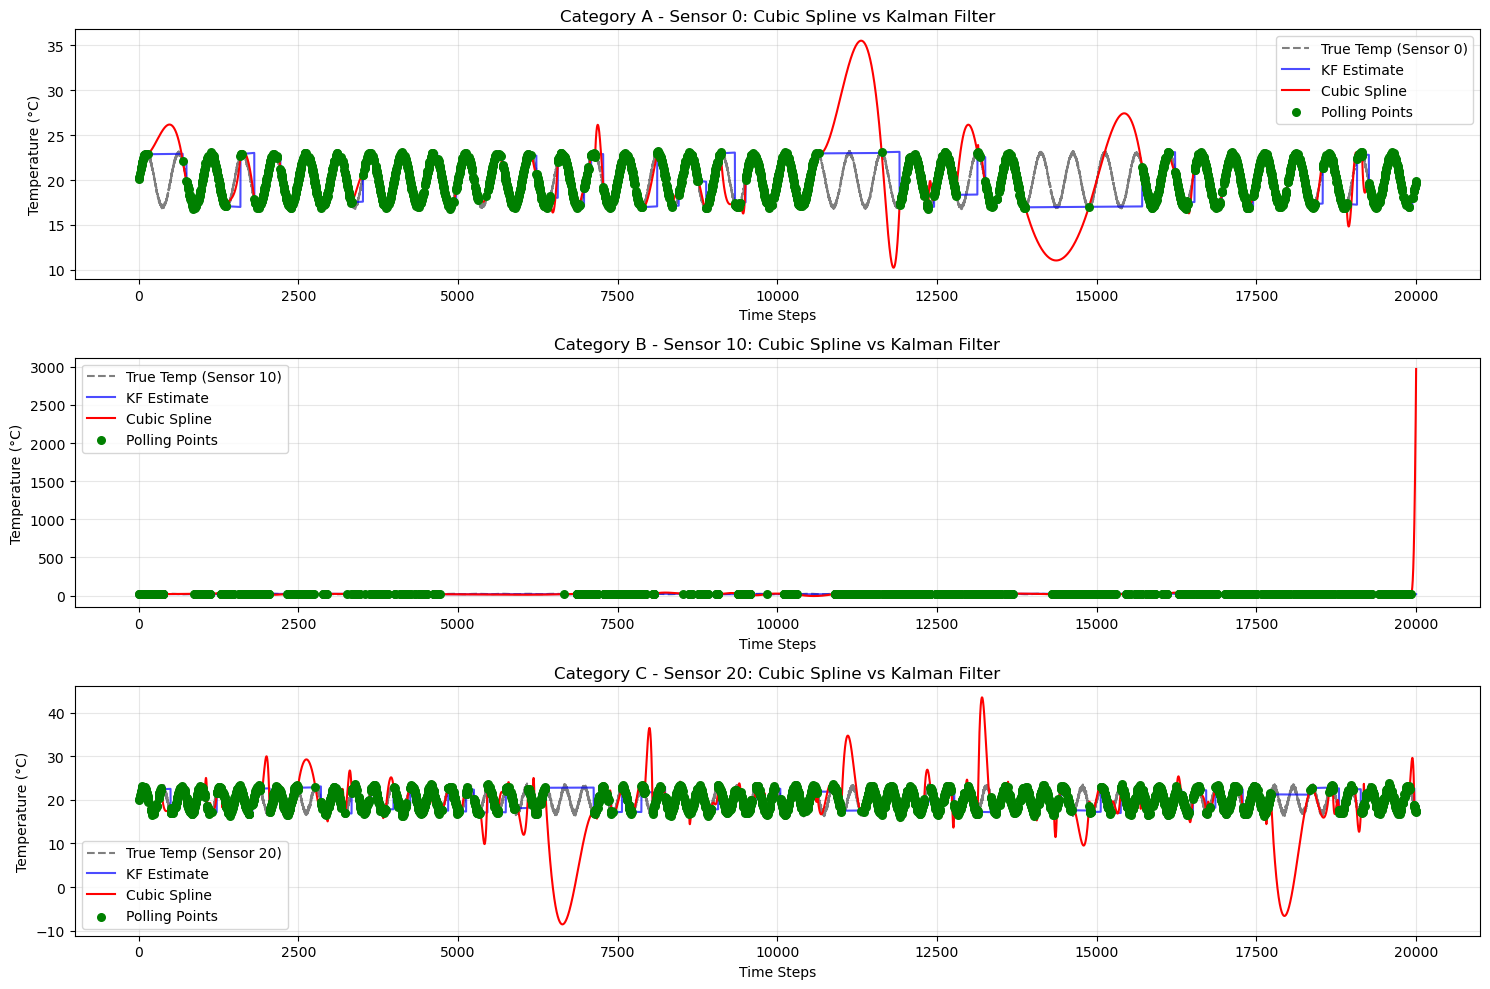


Final Average MSE (all sensors, KF only): 4.238637

Final counts of how many times each category was polled:
Category A: 23127
Category B: 26113
Category C: 30760


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.interpolate import CubicSpline

# Load dataset and preprocess
pivot_df = pd.read_csv("synthetic_scenario_30_nodes_2.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to first 20000 time steps

# Define parameters
num_sensors = pivot_df.shape[1]  # Number of sensors
time_steps = pivot_df.shape[0]  # Number of time steps
M = 5  # Number of sensors to poll at each time step
initial_rate = 0.5  # Initial rate of change to ensure early polling

# Kalman Filter Parameters
dt = 1  # Time step
A = np.array([[1, dt], [0, 1]])  # State transition matrix
H = np.array([[1, 0]])  # Observation matrix (we only measure temperature)
Q = np.array([[1e-3, 0], [0, 1e-3]])  # Process noise covariance
R = np.array([[0.1]])  # Measurement noise covariance

# Initialize Kalman Filter states (temperature & rate of change)
X = np.zeros((num_sensors, 2, 1))  # Initial state for each sensor
X[:, 0, 0] = pivot_df.iloc[0, :].values  # Initialize temperature estimates
X[:, 1, 0] = initial_rate  # Initialize rate of change with nonzero value

# Initial estimate uncertainty (P matrix)
P = np.array([np.eye(2) for _ in range(num_sensors)])  # Covariance per sensor

# Initialize last update times for all sensors
last_update_times = np.zeros(num_sensors)

# Initialize category count tracker
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

# Function to extract node ID from column name
def extract_node_id(column_name):
    try:
        return int(''.join(filter(str.isdigit, column_name)))  # Extract numeric part
    except ValueError:
        return None  # In case of invalid format

# Categorize sensors based on their node IDs
sensor_categories = {}
for i, col in enumerate(pivot_df.columns):
    node_id = extract_node_id(col)
    if node_id is not None:
        if 1 <= node_id <= 10:
            sensor_categories[i] = 'Category A'
        elif 11 <= node_id <= 20:
            sensor_categories[i] = 'Category B'
        elif 21 <= node_id <= 30:
            sensor_categories[i] = 'Category C'

# Select one sensor from each category for spline interpolation
selected_sensors = {}
for cat in ['Category A', 'Category B', 'Category C']:
    for i, category in sensor_categories.items():
        if category == cat:
            selected_sensors[cat] = i
            break

# Track polling timestamps and measurements for selected sensors
spline_data = {
    cat: {
        'timestamps': [0],  # Start with time 0
        'values': [pivot_df.iloc[0, sensor_idx]],  # Initial value 
        'derivatives': [initial_rate]  # Initial rate of change
    } 
    for cat, sensor_idx in selected_sensors.items()
}

# Store estimated temperatures & MSE tracking
estimated_temperatures = np.zeros((time_steps, num_sensors))
estimated_temperatures[0, :] = X[:, 0, 0]  # Initial estimates
mse_list = []

# Kalman filter loop
for t in range(1, time_steps):
    # Step 1: Prediction (for all sensors)
    for i in range(num_sensors):
        X[i] = A @ X[i]  # Predict next state
        P[i] = A @ P[i] @ A.T + Q  # Predict next covariance

    # Step 2: Compute polling scores based on rate of change * time elapsed
    polling_scores = np.array([(t - last_update_times[i]) * abs(X[i, 1, 0]) for i in range(num_sensors)])
    polled_indices = np.argsort(polling_scores)[-M:]  # Select M nodes with highest score

    # Step 3: Update step (only for polled sensors)
    for i in polled_indices:
        Z = np.array([[pivot_df.iloc[t, i]]])  # Measurement for this sensor
        y = Z - (H @ X[i])  # Measurement residual
        S = H @ P[i] @ H.T + R  # Residual covariance
        K = P[i] @ H.T @ np.linalg.inv(S)  # Kalman Gain
        X[i] = X[i] + K @ y  # Update estimate
        P[i] = (np.eye(2) - K @ H) @ P[i]  # Update covariance
        last_update_times[i] = t  # Reset last update time for this node

        # Store polling data for our selected sensors for spline interpolation
        for cat, sensor_idx in selected_sensors.items():
            if i == sensor_idx:
                spline_data[cat]['timestamps'].append(t)
                spline_data[cat]['values'].append(float(Z[0][0]))  # Actual measurement
                spline_data[cat]['derivatives'].append(float(X[i, 1, 0]))  # Rate of change from KF

        # Step 4: Categorize polled sensors
        node_id = extract_node_id(pivot_df.columns[i])
        if node_id is not None:
            if 1 <= node_id <= 10:
                category_counts['Category A'] += 1
            elif 11 <= node_id <= 20:
                category_counts['Category B'] += 1
            elif 21 <= node_id <= 30:
                category_counts['Category C'] += 1

    # Store estimates
    estimated_temperatures[t, :] = X[:, 0, 0]

    # Compute MSE for this time step
    mse_list.append(mean_squared_error(pivot_df.iloc[t, :], estimated_temperatures[t, :]))

# Compute final average MSE
average_mse = np.mean(mse_list)

# Create cubic splines for the selected sensors
spline_estimates = {}
for cat, sensor_idx in selected_sensors.items():
    data = spline_data[cat]
    
    # Only proceed if we have enough points for interpolation
    if len(data['timestamps']) > 3:  # Need at least 4 points for cubic spline
        # Create the cubic spline with derivative information
        cs = CubicSpline(
            data['timestamps'], 
            data['values'],
            bc_type=((1, data['derivatives'][0]), (1, data['derivatives'][-1]))  # Use derivatives as boundary conditions
        )
        
        # Evaluate the spline at all timestamps
        all_times = np.arange(time_steps)
        spline_estimates[cat] = {
            'sensor_idx': sensor_idx,
            'times': all_times,
            'values': cs(all_times)
        }
        
        # Compare MSE between spline interpolation and KF for this sensor
        spline_mse = mean_squared_error(pivot_df.iloc[:, sensor_idx], spline_estimates[cat]['values'])
        kf_mse = mean_squared_error(pivot_df.iloc[:, sensor_idx], estimated_temperatures[:, sensor_idx])
        
        print(f"\n{cat} (Sensor {sensor_idx}):")
        print(f"Number of polling points: {len(data['timestamps'])}")
        print(f"Cubic Spline MSE: {spline_mse:.6f}")
        print(f"Kalman Filter MSE: {kf_mse:.6f}")
        print(f"Improvement: {(kf_mse - spline_mse) / kf_mse * 100:.2f}%")

# Plot results for the selected sensors with spline interpolation
plt.figure(figsize=(15, 10))

for cat, sensor_data in spline_estimates.items():
    sensor_idx = sensor_data['sensor_idx']
    polling_times = spline_data[cat]['timestamps']
    polling_values = spline_data[cat]['values']
    
    # Plot true values
    plt.subplot(3, 1, list(spline_estimates.keys()).index(cat) + 1)
    plt.plot(pivot_df.iloc[:, sensor_idx], label=f"True Temp (Sensor {sensor_idx})", 
             color='black', alpha=0.5, linestyle="dashed")
    
    # Plot KF estimates
    plt.plot(estimated_temperatures[:, sensor_idx], label=f"KF Estimate", 
             color='blue', alpha=0.7)
    
    # Plot cubic spline interpolation
    plt.plot(sensor_data['times'], sensor_data['values'], label="Cubic Spline", 
             color='red', linewidth=1.5)
    
    # Plot the polling points
    plt.scatter(polling_times, polling_values, color='green', label="Polling Points", 
                zorder=5, s=30, marker='o')
    
    plt.xlabel("Time Steps")
    plt.ylabel("Temperature (°C)")
    plt.title(f"{cat} - Sensor {sensor_idx}: Cubic Spline vs Kalman Filter")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display final MSE and category polling counts
print(f"\nFinal Average MSE (all sensors, KF only): {average_mse:.6f}")
print(f"\nFinal counts of how many times each category was polled:")
for cat, count in category_counts.items():
    print(f"{cat}: {count}")

In [80]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Load dataset and preprocess
pivot_df = pd.read_csv("synthetic_scenario_30_nodes_2.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to first 10000 time steps

# Define parameters
num_sensors = pivot_df.shape[1]  # Number of sensors
time_steps = pivot_df.shape[0]  # Number of time steps
M = 5  # Number of sensors to poll at each time step

# Kalman Filter Parameters
dt = 1  # Time step
A = np.array([[1, dt], [0, 1]])  # State transition matrix
H = np.array([[1, 0]])  # Observation matrix (we only measure temperature)
Q = np.array([[1e-3, 0], [0, 1e-3]])  # Process noise covariance
R = np.array([[0.5]])  # Measurement noise covariance

# Initialize Kalman Filter states (temperature & rate of change)
X = np.zeros((num_sensors, 2, 1))  # Initial state for each sensor
X[:, 0, 0] = pivot_df.iloc[0, :].values  # Initialize temperature estimates
X[:, 1, 0] = 0  # Assume initial rate of change is zero

# Initial estimate uncertainty (P matrix)
P = np.array([np.eye(2) for _ in range(num_sensors)])  # Covariance per sensor

# Initialize category count tracker
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

# Function to extract node ID from column name
def extract_node_id(column_name):
    try:
        return int(''.join(filter(str.isdigit, column_name)))  # Extract numeric part
    except ValueError:
        return None  # In case of invalid format

# Categorize sensors
sensor_categories = {}
category_sensors = {'Category A': [], 'Category B': [], 'Category C': []}

for i, col in enumerate(pivot_df.columns):
    node_id = extract_node_id(col)
    if node_id is not None:
        if 1 <= node_id <= 10:
            category = 'Category A'
        elif 11 <= node_id <= 20:
            category = 'Category B'
        elif 21 <= node_id <= 30:
            category = 'Category C'
        else:
            continue
            
        sensor_categories[i] = category
        category_sensors[category].append(i)

# Store estimated temperatures & MSE tracking
estimated_temperatures = np.zeros((time_steps, num_sensors))
estimated_temperatures[0, :] = X[:, 0, 0]  # Initial estimates
mse_list = []
category_mse = {'Category A': [], 'Category B': [], 'Category C': []}

# Kalman filter loop
print("Running Kalman Filter simulation...")
for t in range(1, time_steps):
    # Step 1: Prediction (for all sensors)
    for i in range(num_sensors):
        X[i] = A @ X[i]  # Predict next state
        P[i] = A @ P[i] @ A.T + Q  # Predict next covariance

    # Step 2: Select M sensors to poll (based on largest covariance trace)
    covariance_traces = np.array([np.trace(P[i]) for i in range(num_sensors)])
    polled_indices = np.argsort(covariance_traces)[-M:]  # Select M sensors with highest uncertainty

    # Step 3: Update step (only for polled sensors)
    for i in polled_indices:
        Z = np.array([[pivot_df.iloc[t, i]]])  # Measurement for this sensor
        y = Z - (H @ X[i])  # Measurement residual
        S = H @ P[i] @ H.T + R  # Residual covariance
        K = P[i] @ H.T @ np.linalg.inv(S)  # Kalman Gain
        X[i] = X[i] + K @ y  # Update estimate
        P[i] = (np.eye(2) - K @ H) @ P[i]  # Update covariance

        # Step 4: Categorize polled sensors
        if i in sensor_categories:
            category = sensor_categories[i]
            category_counts[category] += 1

    # Store estimates
    estimated_temperatures[t, :] = X[:, 0, 0]

    # Compute MSE for this time step (overall and per category)
    current_mse = mean_squared_error(pivot_df.iloc[t, :], estimated_temperatures[t, :])
    mse_list.append(current_mse)
    
    # Calculate MSE per category
    for category, sensor_indices in category_sensors.items():
        if sensor_indices:  # Only if category has sensors
            cat_mse = mean_squared_error(
                pivot_df.iloc[t, sensor_indices],
                estimated_temperatures[t, sensor_indices]
            )
            category_mse[category].append(cat_mse)

# Compute final average MSE
average_mse = np.mean(mse_list)
category_avg_mse = {cat: np.mean(mses) for cat, mses in category_mse.items() if mses}

# Calculate RMSE values
overall_rmse = np.sqrt(average_mse)
category_rmse = {cat: np.sqrt(mse) for cat, mse in category_avg_mse.items()}

# Calculate MAE values
overall_mae = np.mean(np.abs(pivot_df.iloc[1:, :].values - estimated_temperatures[1:, :]))
category_mae = {}
for category, sensor_indices in category_sensors.items():
    if sensor_indices:
        mae = np.mean(np.abs(
            pivot_df.iloc[1:, sensor_indices].values - 
            estimated_temperatures[1:, sensor_indices]
        ))
        category_mae[category] = mae

# Print results
print("\n" + "="*50)
print("KALMAN FILTER POLLING RESULTS")
print("="*50)

print("\nPolling Distribution:")
print(f"Total polls: {sum(category_counts.values())}")
for category, count in category_counts.items():
    print(f"  {category}: {count} polls ({count/sum(category_counts.values())*100:.2f}%)")

print("\nError Metrics (Overall):")
print(f"  MSE: {average_mse:.6f}")
print(f"  RMSE: {overall_rmse:.6f}")
print(f"  MAE: {overall_mae:.6f}")

print("\nError Metrics by Category:")
for category in category_sensors.keys():
    if category in category_avg_mse:
        print(f"  {category}:")
        print(f"    MSE: {category_avg_mse[category]:.6f}")
        print(f"    RMSE: {category_rmse[category]:.6f}")
        print(f"    MAE: {category_mae[category]:.6f}")

# Save results to CSV
results_df = pd.DataFrame({
    'Category': ['Overall'] + list(category_sensors.keys()),
    'Polls': [sum(category_counts.values())] + [category_counts.get(cat, 0) for cat in category_sensors.keys()],
    'MSE': [average_mse] + [category_avg_mse.get(cat, 0) for cat in category_sensors.keys()],
    'RMSE': [overall_rmse] + [category_rmse.get(cat, 0) for cat in category_sensors.keys()],
    'MAE': [overall_mae] + [category_mae.get(cat, 0) for cat in category_sensors.keys()]
})

results_df.to_csv("kalman_filter_metrics.csv", index=False)
print("\nResults saved to 'kalman_filter_metrics.csv'")


Running Kalman Filter simulation...

KALMAN FILTER POLLING RESULTS

Polling Distribution:
Total polls: 48388
  Category A: 16108 polls (33.29%)
  Category B: 16149 polls (33.37%)
  Category C: 16131 polls (33.34%)

Error Metrics (Overall):
  MSE: 0.075216
  RMSE: 0.274256
  MAE: 0.191903

Error Metrics by Category:
  Category A:
    MSE: 0.016916
    RMSE: 0.130061
    MAE: 0.099713
  Category B:
    MSE: 0.066448
    RMSE: 0.257775
    MAE: 0.197805
  Category C:
    MSE: 0.149569
    RMSE: 0.386741
    MAE: 0.297268

Results saved to 'kalman_filter_metrics.csv'


In [84]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Load dataset and preprocess
#pivot_df = pd.read_csv("synthetic_scenario_30_nodes_2.csv")
pivot_df = pd.read_csv("simulated_office_environment.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to first 10000 time steps

# Define parameter values to test
m_values = [1, 2, 5, 10]

# Function to extract node ID from column name
def extract_node_id(column_name):
    try:
        return int(''.join(filter(str.isdigit, column_name)))  # Extract numeric part
    except ValueError:
        return None  # In case of invalid format

# Categorize sensors
def categorize_sensors(pivot_df):
    num_sensors = pivot_df.shape[1]
    sensor_categories = {}
    category_sensors = {'Category A': [], 'Category B': [], 'Category C': []}

    for i, col in enumerate(pivot_df.columns):
        node_id = extract_node_id(col)
        if node_id is not None:
            if 1 <= node_id <= 10:
                category = 'Category A'
            elif 11 <= node_id <= 20:
                category = 'Category B'
            elif 21 <= node_id <= 30:
                category = 'Category C'
            else:
                continue
                
            sensor_categories[i] = category
            category_sensors[category].append(i)
    
    return sensor_categories, category_sensors

# Function to run Kalman Filter simulation with a specific M value
def run_kalman_filter(pivot_df, M):
    num_sensors = pivot_df.shape[1]
    time_steps = pivot_df.shape[0]
    
    # Kalman Filter Parameters
    dt = 1  # Time step
    A = np.array([[1, dt], [0, 1]])  # State transition matrix
    H = np.array([[1, 0]])  # Observation matrix (we only measure temperature)
    Q = np.array([[1e-3, 0], [0, 1e-3]])  # Process noise covariance
    R = np.array([[0.5]])  # Measurement noise covariance
    
    # Initialize Kalman Filter states (temperature & rate of change)
    X = np.zeros((num_sensors, 2, 1))  # Initial state for each sensor
    X[:, 0, 0] = pivot_df.iloc[0, :].values  # Initialize temperature estimates
    X[:, 1, 0] = 0  # Assume initial rate of change is zero
    
    # Initial estimate uncertainty (P matrix)
    P = np.array([np.eye(2) for _ in range(num_sensors)])  # Covariance per sensor
    
    # Get sensor categories
    sensor_categories, category_sensors = categorize_sensors(pivot_df)
    
    # Initialize category count tracker
    category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}
    
    # Store estimated temperatures & MSE tracking
    estimated_temperatures = np.zeros((time_steps, num_sensors))
    estimated_temperatures[0, :] = X[:, 0, 0]  # Initial estimates
    mse_list = []
    category_mse = {'Category A': [], 'Category B': [], 'Category C': []}
    
    # Kalman filter loop
    for t in range(1, time_steps):
        # Step 1: Prediction (for all sensors)
        for i in range(num_sensors):
            X[i] = A @ X[i]  # Predict next state
            P[i] = A @ P[i] @ A.T + Q  # Predict next covariance
    
        # Step 2: Select M sensors to poll (based on largest covariance trace)
        covariance_traces = np.array([np.trace(P[i]) for i in range(num_sensors)])
        polled_indices = np.argsort(covariance_traces)[-M:]  # Select M sensors with highest uncertainty
    
        # Step 3: Update step (only for polled sensors)
        for i in polled_indices:
            Z = np.array([[pivot_df.iloc[t, i]]])  # Measurement for this sensor
            y = Z - (H @ X[i])  # Measurement residual
            S = H @ P[i] @ H.T + R  # Residual covariance
            K = P[i] @ H.T @ np.linalg.inv(S)  # Kalman Gain
            X[i] = X[i] + K @ y  # Update estimate
            P[i] = (np.eye(2) - K @ H) @ P[i]  # Update covariance
    
            # Step 4: Categorize polled sensors
            if i in sensor_categories:
                category = sensor_categories[i]
                category_counts[category] += 1
    
        # Store estimates
        estimated_temperatures[t, :] = X[:, 0, 0]
    
        # Compute MSE for this time step (overall and per category)
        current_mse = mean_squared_error(pivot_df.iloc[t, :], estimated_temperatures[t, :])
        mse_list.append(current_mse)
        
        # Calculate MSE per category
        for category, sensor_indices in category_sensors.items():
            if sensor_indices:  # Only if category has sensors
                cat_mse = mean_squared_error(
                    pivot_df.iloc[t, sensor_indices],
                    estimated_temperatures[t, sensor_indices]
                )
                category_mse[category].append(cat_mse)
    
    # Compute final average MSE
    average_mse = np.mean(mse_list)
    category_avg_mse = {cat: np.mean(mses) for cat, mses in category_mse.items() if mses}
    
    # Calculate RMSE values
    overall_rmse = np.sqrt(average_mse)
    category_rmse = {cat: np.sqrt(mse) for cat, mse in category_avg_mse.items()}
    
    # Calculate MAE values
    overall_mae = np.mean(np.abs(pivot_df.iloc[1:, :].values - estimated_temperatures[1:, :]))
    category_mae = {}
    for category, sensor_indices in category_sensors.items():
        if sensor_indices:
            mae = np.mean(np.abs(
                pivot_df.iloc[1:, sensor_indices].values - 
                estimated_temperatures[1:, sensor_indices]
            ))
            category_mae[category] = mae
    
    results = {
        'M': M,
        'total_polls': sum(category_counts.values()),
        'category_counts': category_counts,
        'mse': {
            'overall': average_mse,
            'by_category': category_avg_mse
        },
        'rmse': {
            'overall': overall_rmse,
            'by_category': category_rmse
        },
        'mae': {
            'overall': overall_mae,
            'by_category': category_mae
        }
    }
    
    return results

# Run simulations for all M values
print("Running Kalman Filter simulations for different M values...")
results_by_m = {}

for M in m_values:
    print(f"Processing M = {M}...")
    results_by_m[M] = run_kalman_filter(pivot_df, M)
    print(f"Completed M = {M}")

# Print results in a tabular format
print("\n" + "="*80)
print(f"{'M':<5}{'Total Polls':<15}{'MSE':<15}{'RMSE':<15}{'MAE':<15}")
print("="*80)

for M in m_values:
    result = results_by_m[M]
    print(f"{M:<5}{result['total_polls']:<15,d}{result['mse']['overall']:<15.6f}{result['rmse']['overall']:<15.6f}{result['mae']['overall']:<15.6f}")

print("-"*80)

# Print category-specific results for each M value
print("\nDetailed Results by Category:")
print("="*90)

for M in m_values:
    result = results_by_m[M]
    print(f"\nM = {M}:")
    print("-"*80)
    print(f"{'Category':<12}{'Polls':<12}{'MSE':<15}{'RMSE':<15}{'MAE':<15}{'Poll %':<10}")
    print("-"*80)
    
    total_polls = result['total_polls']
    
    for category in ['Category A', 'Category B', 'Category C']:
        count = result['category_counts'].get(category, 0)
        poll_percent = (count / total_polls * 100) if total_polls > 0 else 0
        
        mse = result['mse']['by_category'].get(category, 0)
        rmse = result['rmse']['by_category'].get(category, 0)
        mae = result['mae']['by_category'].get(category, 0)
        
        print(f"{category:<12}{count:<12,d}{mse:<15.6f}{rmse:<15.6f}{mae:<15.6f}{poll_percent:<10.2f}%")

# Save results to CSV
results_data = []

# Overall results
for M in m_values:
    result = results_by_m[M]
    row = {
        'M': M,
        'Category': 'Overall',
        'Polls': result['total_polls'],
        'MSE': result['mse']['overall'],
        'RMSE': result['rmse']['overall'],
        'MAE': result['mae']['overall'],
        'Poll_Percentage': 100.0
    }
    results_data.append(row)
    
    # Category-specific results
    for category in ['Category A', 'Category B', 'Category C']:
        count = result['category_counts'].get(category, 0)
        poll_percent = (count / result['total_polls'] * 100) if result['total_polls'] > 0 else 0
        
        row = {
            'M': M,
            'Category': category,
            'Polls': count,
            'MSE': result['mse']['by_category'].get(category, 0),
            'RMSE': result['rmse']['by_category'].get(category, 0),
            'MAE': result['mae']['by_category'].get(category, 0),
            'Poll_Percentage': poll_percent
        }
        results_data.append(row)

results_df = pd.DataFrame(results_data)
results_df.to_csv("kalman_filter_m_comparison.csv", index=False)
print("\nResults saved to 'kalman_filter_m_comparison.csv'")

Running Kalman Filter simulations for different M values...
Processing M = 1...
Completed M = 1
Processing M = 2...
Completed M = 2
Processing M = 5...
Completed M = 5
Processing M = 10...
Completed M = 10

M    Total Polls    MSE            RMSE           MAE            
1    9,676          172.869615     13.147989      8.102862       
2    19,352         120.746528     10.988473      6.765430       
5    48,388         72.034871      8.487336       5.197817       
10   96,765         51.876946      7.202565       4.421757       
--------------------------------------------------------------------------------

Detailed Results by Category:

M = 1:
--------------------------------------------------------------------------------
Category    Polls       MSE            RMSE           MAE            Poll %    
--------------------------------------------------------------------------------
Category A  3,227       0.152854       0.390965       0.302160       33.35     %
Category B  3,226   

Transmission Count by Category:
Category A: 349 times
Category B: 261 times
Category C: 179 times


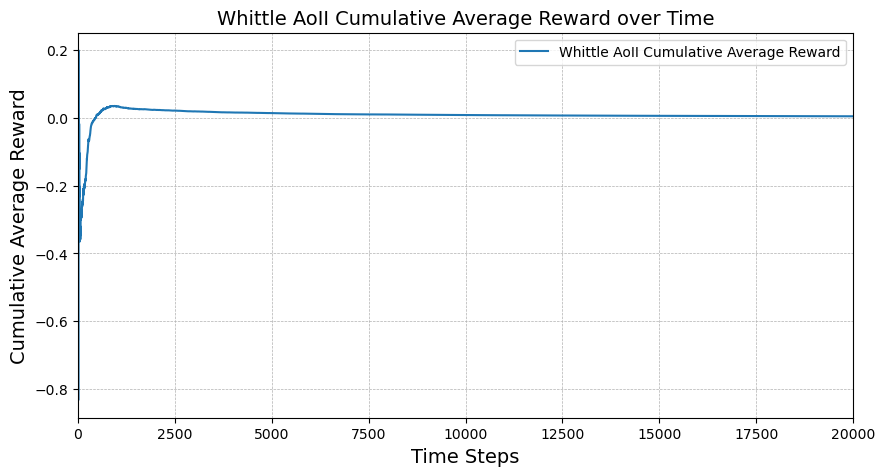

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset and preprocess
pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(20000)  # Restrict to first 20000 time steps

# Parameters
reward = 0.5
M = 5  # Maximum number of nodes that can be polled
theta = 0.5  # Threshold for reward condition
penalty = -0.5  # Penalty for polling when difference is <= theta
aoii_penalty = 0.5
initial_value = 20  # Initial estimate for last polled values

# Set parameters
beta_1 = 0.95  # dEWMA parameter for state value
beta_2 = 0.1 # dEWMA parameter for rate of change

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Track the number of times each category is pulled
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    return abs((current_time - last_received_time) * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Helper function to calculate reward
def calculate_reward(measured_value, last_state_value, theta, penalty):
    if abs(measured_value - last_state_value) > theta:
        return reward  # Reward
    return penalty  # Penalty

# Function to extract numeric node ID from column names dynamically, ensuring valid extraction
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Main function to simulate Whittle AoII with rewards and track transmission counts
def run_simulation_whittle_aoii(pivot_df, columns, M, theta, penalty, aoii_penalty):
    cumulative_reward = 0  # Track total cumulative reward
    cumulative_rewards = []  # Store cumulative average reward over time
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states

    for t in range(len(pivot_df)):
        # Step 1: Compute Whittle indices for each node based on AoII
        whittle_indices = {}
        for col in columns:
            last_state_value, last_rate_of_change = state_node[col]
            measured_value = pivot_df.loc[t, col]

            # Correct AoII calculation at the sink using rate of change
            current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
            future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
            future_aoii_active = 0  # AoII resets to 0 if polled

            # Whittle index calculations
            q_passive = current_aoii + future_aoii_passive
            q_active = current_aoii + future_aoii_active + aoii_penalty
            whittle_indices[col] = q_passive - q_active

        # Step 2: Select top M nodes to poll based on Whittle indices
        nodes_to_poll = [col for col in whittle_indices if whittle_indices[col] >= 0]
        if len(nodes_to_poll) > M:
            nodes_to_poll = sorted(nodes_to_poll, key=whittle_indices.get, reverse=True)[:M]

        # Step 3: Poll selected nodes and calculate rewards
        for col in nodes_to_poll:
            measured_value = pivot_df.loc[t, col]
            last_state_value, last_rate_of_change = state_node[col]

            # Calculate reward after polling
            reward = calculate_reward(measured_value, last_state_value, theta, penalty)
            cumulative_reward += reward  # Update cumulative reward

            delta_t_dynamic = t - last_update_times[col]  # Time since last update

            # Update node state and last update time
            state_node[col] = update_node_state_dewma(
                measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1=beta_1, beta_2=beta_2
            )
            last_update_times[col] = t

            # Extract node ID dynamically and categorize
            node_id = extract_node_id(col)
            if node_id is not None:
                if 1 <= node_id <= 10:
                    category_counts['Category A'] += 1
                elif 11 <= node_id <= 20:
                    category_counts['Category B'] += 1
                elif 21 <= node_id <= 30:
                    category_counts['Category C'] += 1

        # Step 4: Calculate cumulative average reward
        cumulative_rewards.append(cumulative_reward / (t + 1))

    return cumulative_rewards, category_counts

# Run the simulation
cumulative_rewards_whittle, category_pulled_counts = run_simulation_whittle_aoii(
    pivot_df, columns, M, theta, penalty, aoii_penalty
)

# Print the number of times each category was pulled
print("Transmission Count by Category:")
for category, count in category_pulled_counts.items():
    print(f"{category}: {count} times")

# Save cumulative rewards to CSV
pd.DataFrame(cumulative_rewards_whittle, columns=["cumulative_reward"]).to_csv(
    "cumulative_rewards_whittle_aoii_final.csv", index=False
)

# Plot cumulative average reward over time
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_rewards_whittle) + 1), cumulative_rewards_whittle, label='Whittle AoII Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Cumulative Average Reward', fontsize=14)
plt.title('Whittle AoII Cumulative Average Reward over Time', fontsize=14)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(0, len(cumulative_rewards_whittle))

# Save the plot
plt.savefig("whittle_aoii_cumulative_average_reward_final.png")

plt.show()


Transmission Count by Category:
Category A: 825 times
Category B: 1482 times
Category C: 3668 times


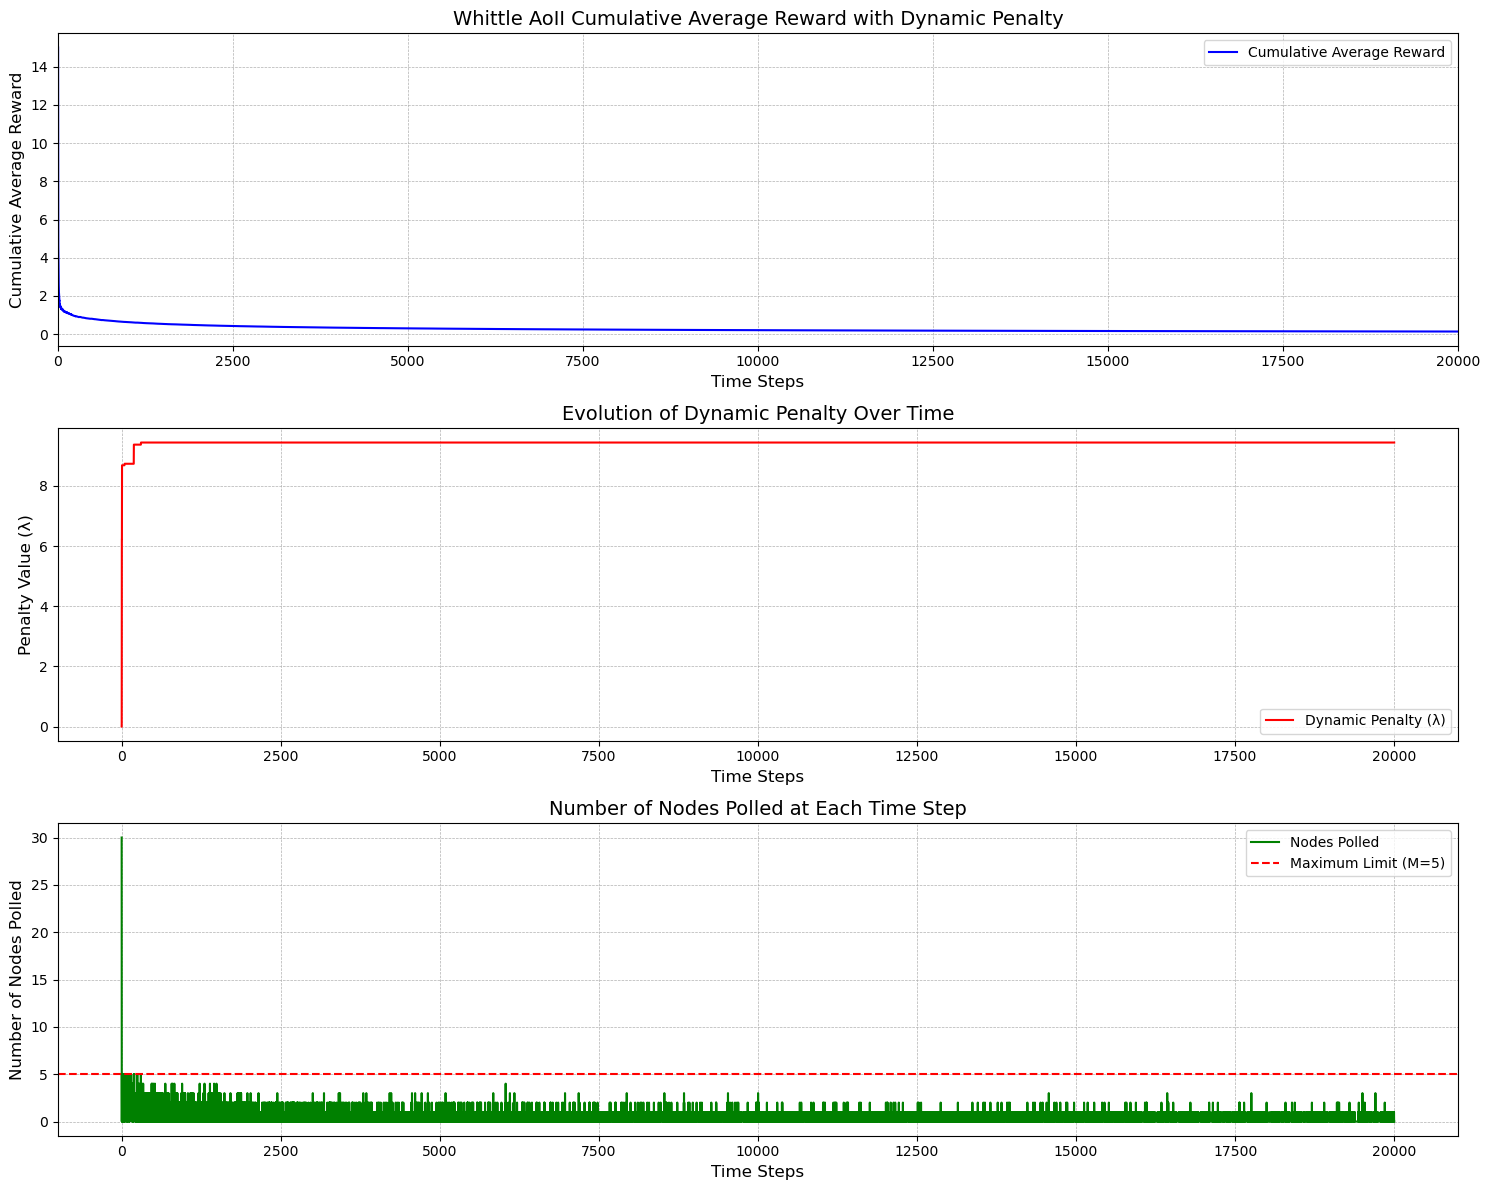

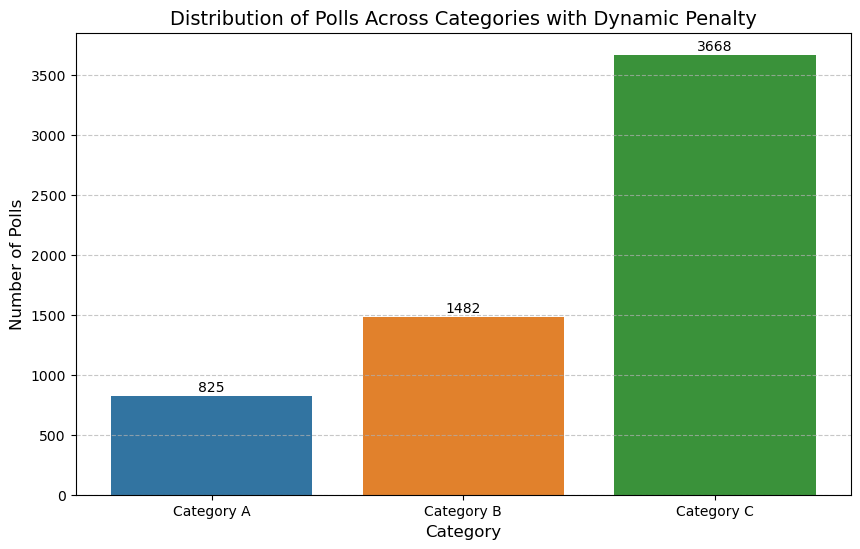


Dynamic Penalty Statistics:
Average Penalty: 9.4368
Maximum Penalty: 9.4452
Minimum Penalty: 0.0000

Nodes Polled Statistics:
Average Nodes Polled per Time Step: 0.30
Maximum Nodes Polled at any Time Step: 30
Target Maximum (M): 5


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset and preprocess
#pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
pivot_df = pd.read_csv("simulated_office_environment.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to first 20000 time steps

# Parameters
reward = 0.5
M = 5  # Maximum number of nodes that can be polled
theta = 0.5  # Threshold for reward condition
penalty = -0.5  # Penalty for polling when difference is <= theta
initial_value = 20  # Initial estimate for last polled values

# Set parameters
beta_1 = 0.95  # dEWMA parameter for state value
beta_2 = 0.01 # dEWMA parameter for rate of change

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Track the number of times each category is pulled
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    # Handle potential NaN or Inf values
    time_diff = current_time - last_received_time
    if np.isnan(last_rate_of_change) or np.isinf(last_rate_of_change):
        return 0.0  # Default to zero if rate of change is invalid
    return abs(time_diff * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    # Handle the case where delta_t is 0 to avoid division by zero
    if delta_t == 0:
        return measured_value, last_rate_of_change  # Return measured value and keep the last rate of change
    
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Helper function to calculate reward
def calculate_reward(measured_value, last_state_value, theta, penalty):
    if abs(measured_value - last_state_value) > theta:
        return reward  # Reward
    return penalty  # Penalty

# Function to extract numeric node ID from column names dynamically, ensuring valid extraction
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Dynamic Penalty Update algorithm based on Whittle indices
def dynamic_penalty_update(whittle_indices, M, current_lambda):
    # Convert dictionary values to a list of whittle indices, handling any NaN values
    c_values = []
    for v in whittle_indices.values():
        if np.isnan(v):
            c_values.append(-float('inf'))  # Treat NaN as negative infinity (won't be polled)
        else:
            c_values.append(v)
    
    # Identify the set ℰ of nodes where c_i > λ(t)
    eligible_nodes = [i for i, c_i in enumerate(c_values) if c_i > current_lambda]
    
    # If |ℰ| ≤ M, no penalty update needed
    if len(eligible_nodes) <= M:
        return current_lambda
    
    # Sort the c_i values in descending order
    sorted_c_values = sorted(c_values, reverse=True)
    
    # Identify the M-th value
    M_th_value = sorted_c_values[M-1]
    
    # Update penalty to the M-th value
    new_lambda = M_th_value
    
    return new_lambda

# Main function to simulate Whittle AoII with rewards and track transmission counts
def run_simulation_whittle_aoii_dynamic_penalty(pivot_df, columns, M, theta, penalty):
    cumulative_reward = 0  # Track total cumulative reward
    cumulative_rewards = []  # Store cumulative average reward over time
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states
    
    # Initialize dynamic penalty (λ) to 0
    aoii_penalty = 0.0
    
    # Track penalty evolution
    penalty_values = [aoii_penalty]
    
    # Track nodes polled at each time step
    nodes_polled_count = []
    
    # Set minimum timestamp difference to avoid division by zero
    min_delta_t = 1  # Minimum time difference of 1 to avoid division by zero

    for t in range(len(pivot_df)):
        # Step 1: Compute Whittle indices for each node based on AoII
        whittle_indices = {}
        for col in columns:
            last_state_value, last_rate_of_change = state_node[col]
            measured_value = pivot_df.loc[t, col]

            # Correct AoII calculation at the sink using rate of change
            current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
            future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
            future_aoii_active = 0  # AoII resets to 0 if polled

            # Whittle index calculations - with safety checks for NaN/Inf values
            q_passive = current_aoii + future_aoii_passive
            q_active = current_aoii + future_aoii_active + aoii_penalty
            
            # Calculate the Whittle index with safeguards against invalid values
            whittle_index = q_passive - q_active
            
            # Handle NaN or Inf values
            if np.isnan(whittle_index) or np.isinf(whittle_index):
                whittle_indices[col] = -float('inf')  # Set to negative infinity if invalid
            else:
                whittle_indices[col] = whittle_index

        # Step 2: Update the dynamic penalty (λ) using the algorithm
        aoii_penalty = dynamic_penalty_update(whittle_indices, M, aoii_penalty)
        penalty_values.append(aoii_penalty)
        
        # Step 3: Select nodes to poll based on the updated penalty
        nodes_to_poll = [col for col in whittle_indices if whittle_indices[col] >= aoii_penalty]
        nodes_polled_count.append(len(nodes_to_poll))

        # Step 4: Poll selected nodes and calculate rewards
        for col in nodes_to_poll:
            measured_value = pivot_df.loc[t, col]
            last_state_value, last_rate_of_change = state_node[col]

            # Calculate reward after polling
            reward = calculate_reward(measured_value, last_state_value, theta, penalty)
            cumulative_reward += reward  # Update cumulative reward

            delta_t_dynamic = max(min_delta_t, t - last_update_times[col])  # Time since last update (ensure at least 1)

            # Update node state and last update time
            state_node[col] = update_node_state_dewma(
                measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1=beta_1, beta_2=beta_2
            )
            last_update_times[col] = t

            # Extract node ID dynamically and categorize
            node_id = extract_node_id(col)
            if node_id is not None:
                if 1 <= node_id <= 10:
                    category_counts['Category A'] += 1
                elif 11 <= node_id <= 20:
                    category_counts['Category B'] += 1
                elif 21 <= node_id <= 30:
                    category_counts['Category C'] += 1

        # Step 5: Calculate cumulative average reward
        cumulative_rewards.append(cumulative_reward / (t + 1))

    return cumulative_rewards, category_counts, penalty_values, nodes_polled_count

# Run the simulation with dynamic penalty
cumulative_rewards_whittle, category_pulled_counts, penalty_values, nodes_polled_count = run_simulation_whittle_aoii_dynamic_penalty(
    pivot_df, columns, M, theta, penalty
)

# Print the number of times each category was pulled
print("Transmission Count by Category:")
for category, count in category_pulled_counts.items():
    print(f"{category}: {count} times")

# Save cumulative rewards to CSV
pd.DataFrame(cumulative_rewards_whittle, columns=["cumulative_reward"]).to_csv(
    "cumulative_rewards_whittle_dynamic_penalty.csv", index=False
)

# Create a figure with 3 subplots
plt.figure(figsize=(15, 12))

# Plot 1: Cumulative average reward over time
plt.subplot(3, 1, 1)
plt.plot(range(1, len(cumulative_rewards_whittle) + 1), cumulative_rewards_whittle, 
         label='Cumulative Average Reward', color='blue')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Cumulative Average Reward', fontsize=12)
plt.title('Whittle AoII Cumulative Average Reward with Dynamic Penalty', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(0, len(cumulative_rewards_whittle))
plt.legend()

# Plot 2: Evolution of the dynamic penalty (λ)
plt.subplot(3, 1, 2)
plt.plot(range(len(penalty_values)), penalty_values, label='Dynamic Penalty (λ)', color='red')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Penalty Value (λ)', fontsize=12)
plt.title('Evolution of Dynamic Penalty Over Time', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Plot 3: Number of nodes polled at each time step
plt.subplot(3, 1, 3)
plt.plot(range(len(nodes_polled_count)), nodes_polled_count, label='Nodes Polled', color='green')
plt.axhline(y=M, color='r', linestyle='--', label=f'Maximum Limit (M={M})')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Number of Nodes Polled', fontsize=12)
plt.title('Number of Nodes Polled at Each Time Step', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

plt.tight_layout()
plt.savefig("whittle_aoii_dynamic_penalty_analysis.png", dpi=300)
plt.show()

# Additional analysis: Plot category distribution
plt.figure(figsize=(10, 6))
categories = list(category_pulled_counts.keys())
counts = list(category_pulled_counts.values())
plt.bar(categories, counts, color=['#3274A1', '#E1812C', '#3A923A'])
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Polls', fontsize=12)
plt.title('Distribution of Polls Across Categories with Dynamic Penalty', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add count labels on top of each bar
for i, count in enumerate(counts):
    plt.text(i, count + (max(counts) * 0.01), f'{count}', ha='center', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("category_distribution_dynamic_penalty.png", dpi=300)
plt.show()

# Calculate statistics about the penalty values and nodes polled
avg_penalty = np.mean(penalty_values)
max_penalty = np.max(penalty_values)
min_penalty = np.min(penalty_values)
avg_nodes_polled = np.mean(nodes_polled_count)
max_nodes_polled = np.max(nodes_polled_count)

print(f"\nDynamic Penalty Statistics:")
print(f"Average Penalty: {avg_penalty:.4f}")
print(f"Maximum Penalty: {max_penalty:.4f}")
print(f"Minimum Penalty: {min_penalty:.4f}")
print(f"\nNodes Polled Statistics:")
print(f"Average Nodes Polled per Time Step: {avg_nodes_polled:.2f}")
print(f"Maximum Nodes Polled at any Time Step: {max_nodes_polled}")
print(f"Target Maximum (M): {M}")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load dataset and preprocess
#pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
#pivot_df = pd.read_csv("simulated_environment_data.csv")
pivot_df = pd.read_csv("synthetic_scenario_30_nodes_2.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to first 20000 time steps

# Parameters
reward = 0.5
M = 5  # Maximum number of nodes that can be polled
theta = 0.3  # Threshold for reward condition
penalty = -0.3  # Penalty for polling when difference is <= theta
aoii_penalty = 0.5
initial_value = 20  # Initial estimate for last polled values
L = 200 # Fairness threshold: maximum time a node can go without being polled

# Set parameters
beta_1 = 0.9  # dEWMA parameter for state value
beta_2 = 0.9  # dEWMA parameter for rate of change

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Track the number of times each category is pulled
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    # Handle potential NaN or Inf values
    if np.isnan(last_rate_of_change) or np.isinf(last_rate_of_change):
        return 0.0  # Default to zero if rate of change is invalid
    return abs((current_time - last_received_time) * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    # Handle the case where delta_t is 0 to avoid division by zero
    if delta_t == 0:
        return measured_value, last_rate_of_change  # Return measured value and keep the last rate of change
    
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Helper function to calculate reward
def calculate_reward(measured_value, last_state_value, theta, penalty):
    if abs(measured_value - last_state_value) > theta:
        return reward  # Reward
    return penalty  # Penalty

# Function to extract numeric node ID from column names dynamically, ensuring valid extraction
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Main function to simulate Whittle AoII with rewards and track transmission counts, with fairness
def run_simulation_whittle_aoii_with_fairness(pivot_df, columns, M, theta, penalty, aoii_penalty, L):
    cumulative_reward = 0  # Track total cumulative reward
    cumulative_rewards = []  # Store cumulative average reward over time
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states
    
    # Track estimated values and MSE
    estimated_values = {col: np.zeros(len(pivot_df)) for col in columns}
    mse_per_timestep = []
    category_mse = {'Category A': [], 'Category B': [], 'Category C': []}
    forced_polls_count = 0  # Track how many times the fairness constraint is activated
    
    # Fairness tracking
    fairness_activations = []  # Track timesteps where fairness is activated
    nodes_polled_by_fairness = {}  # Track which nodes were polled due to fairness
    
    # Set minimum timestamp difference to avoid division by zero
    min_delta_t = 1  # Minimum time difference of 1 to avoid division by zero
    
    # Initialize estimated values with initial state
    for col in columns:
        estimated_values[col][0] = state_node[col][0]

    for t in range(len(pivot_df)):
        # Step 1: Compute Whittle indices for each node based on AoII
        whittle_indices = {}
        for col in columns:
            last_state_value, last_rate_of_change = state_node[col]

            # Correct AoII calculation at the sink using rate of change
            current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
            future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
            future_aoii_active = 0  # AoII resets to 0 if polled

            # Whittle index calculations - with safety checks for NaN/Inf values
            q_passive = current_aoii + future_aoii_passive
            q_active = current_aoii + future_aoii_active + aoii_penalty
            
            # Calculate the Whittle index with safeguards against invalid values
            whittle_index = q_passive - q_active
            
            # Handle NaN or Inf values
            if np.isnan(whittle_index) or np.isinf(whittle_index):
                whittle_indices[col] = -float('inf')  # Set to negative infinity if invalid
            else:
                whittle_indices[col] = whittle_index

        # Step 2: Select top M nodes to poll based on Whittle indices
        nodes_to_poll = [col for col in whittle_indices if whittle_indices[col] >= 0]
        if len(nodes_to_poll) > M:
            nodes_to_poll = sorted(nodes_to_poll, key=whittle_indices.get, reverse=True)[:M]
        
        # Step 3: Identify nodes that haven't been polled for L time steps
        starved_nodes = []
        for col in columns:
            if t - last_update_times[col] >= L and col not in nodes_to_poll:
                starved_nodes.append(col)
        
        # Step 4: Apply fairness constraint - replace least valuable nodes with starved nodes
        fairness_applied = False
        if starved_nodes:
            fairness_activations.append(t)
            fairness_applied = True
            
            # Sort nodes_to_poll by their Whittle indices (ascending order - lowest first)
            nodes_to_poll_sorted = sorted(nodes_to_poll, key=whittle_indices.get)
            
            # Replace the nodes with lowest Whittle indices with starved nodes
            for starved_node in starved_nodes:
                if nodes_to_poll_sorted:
                    # Record the node being replaced due to fairness
                    replaced_node = nodes_to_poll_sorted.pop(0)  # Remove the node with lowest index
                    nodes_to_poll.remove(replaced_node)  # Remove from original list
                    nodes_to_poll.append(starved_node)  # Add the starved node
                    
                    # Track this fairness-based polling
                    forced_polls_count += 1
                    if starved_node not in nodes_polled_by_fairness:
                        nodes_polled_by_fairness[starved_node] = 0
                    nodes_polled_by_fairness[starved_node] += 1
                else:
                    break  # No more nodes to replace
        
        # Step 5: Poll selected nodes and calculate rewards
        for col in nodes_to_poll:
            measured_value = pivot_df.loc[t, col]
            last_state_value, last_rate_of_change = state_node[col]

            # Calculate reward after polling
            reward_value = calculate_reward(measured_value, last_state_value, theta, penalty)
            cumulative_reward += reward_value  # Update cumulative reward

            delta_t_dynamic = max(min_delta_t, t - last_update_times[col])  # Time since last update (ensure at least 1)

            # Update node state and last update time
            state_node[col] = update_node_state_dewma(
                measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1=beta_1, beta_2=beta_2
            )
            last_update_times[col] = t

            # Extract node ID dynamically and categorize
            node_id = extract_node_id(col)
            if node_id is not None:
                if 1 <= node_id <= 10:
                    category_counts['Category A'] += 1
                elif 11 <= node_id <= 20:
                    category_counts['Category B'] += 1
                elif 21 <= node_id <= 30:
                    category_counts['Category C'] += 1

        # Step 6: Update estimated values for all nodes (polled and non-polled)
        for col in columns:
            if col in nodes_to_poll:
                # For polled nodes, use the actual measurement
                estimated_values[col][t] = float(pivot_df.loc[t, col])
            else:
                # For non-polled nodes, use the predicted value from the state model
                last_state_value, last_rate_of_change = state_node[col]
                delta_t_since_last = max(min_delta_t, t - last_update_times[col])
                # Predict using the linear model: x(t) = x(t-1) + rate * delta_t
                estimated_values[col][t] = last_state_value + last_rate_of_change * delta_t_since_last
        
        # Calculate MSE for this time step (overall)
        true_values = np.array([pivot_df.loc[t, col] for col in columns])
        estimated = np.array([estimated_values[col][t] for col in columns])
        current_mse = mean_squared_error(true_values, estimated)
        mse_per_timestep.append(current_mse)
        
        # Calculate MSE per category
        for category in ['Category A', 'Category B', 'Category C']:
            category_cols = []
            for col in columns:
                node_id = extract_node_id(col)
                if node_id is not None:
                    if category == 'Category A' and 1 <= node_id <= 10:
                        category_cols.append(col)
                    elif category == 'Category B' and 11 <= node_id <= 20:
                        category_cols.append(col)
                    elif category == 'Category C' and 21 <= node_id <= 30:
                        category_cols.append(col)
            
            if category_cols:
                cat_true_values = np.array([pivot_df.loc[t, col] for col in category_cols])
                cat_estimated = np.array([estimated_values[col][t] for col in category_cols])
                cat_mse = mean_squared_error(cat_true_values, cat_estimated)
                category_mse[category].append(cat_mse)

        # Step 7: Calculate cumulative average reward
        cumulative_rewards.append(cumulative_reward / (t + 1))

    # Fairness metrics
    fairness_metrics = {
        'fairness_activations': fairness_activations,
        'forced_polls_count': forced_polls_count,
        'nodes_polled_by_fairness': nodes_polled_by_fairness
    }

    return (cumulative_rewards, category_counts, mse_per_timestep, category_mse, 
            estimated_values, fairness_metrics)

# Run the simulation with fairness constraint
results = run_simulation_whittle_aoii_with_fairness(
    pivot_df, columns, M, theta, penalty, aoii_penalty, L
)

cumulative_rewards_whittle, category_pulled_counts, mse_per_timestep, category_mse, estimated_values, fairness_metrics = results

# Print the number of times each category was pulled
print("Transmission Count by Category:")
for category, count in category_pulled_counts.items():
    print(f"{category}: {count} times")

# Print fairness metrics
print(f"\nFairness Metrics (L={L}):")
print(f"Fairness constraint activated {len(fairness_metrics['fairness_activations'])} times")
print(f"Forced polls due to fairness: {fairness_metrics['forced_polls_count']}")
print(f"Number of unique nodes polled by fairness: {len(fairness_metrics['nodes_polled_by_fairness'])}")

# Calculate average MSE values
avg_mse = np.mean(mse_per_timestep)
avg_category_mse = {category: np.mean(mse_list) if mse_list else 0 
                    for category, mse_list in category_mse.items()}

# Display comprehensive performance metrics
print(f"\n=== Performance Metrics ===")
print(f"\nMSE Statistics:")
print(f"Overall Average MSE: {avg_mse:.6f}")
print(f"MSE by Category:")
for category, mse in avg_category_mse.items():
    print(f"  {category}: {mse:.6f}")

print(f"\nCategory Poll Distribution:")
total_polls = sum(category_pulled_counts.values())
for category, count in category_pulled_counts.items():
    print(f"  {category}: {count} polls ({count/total_polls*100:.2f}%)")

# Save cumulative rewards to CSV
pd.DataFrame(cumulative_rewards_whittle, columns=["cumulative_reward"]).to_csv(
    "cumulative_rewards_whittle_fairness.csv", index=False
)



Transmission Count by Category:
Category A: 5856 times
Category B: 6012 times
Category C: 7538 times

Fairness Metrics (L=200):
Fairness constraint activated 1099 times
Forced polls due to fairness: 674
Number of unique nodes polled by fairness: 30

=== Performance Metrics ===

MSE Statistics:
Overall Average MSE: 4.244818
MSE by Category:
  Category A: 3.153464
  Category B: 4.312816
  Category C: 5.268174

Category Poll Distribution:
  Category A: 5856 polls (30.18%)
  Category B: 6012 polls (30.98%)
  Category C: 7538 polls (38.84%)


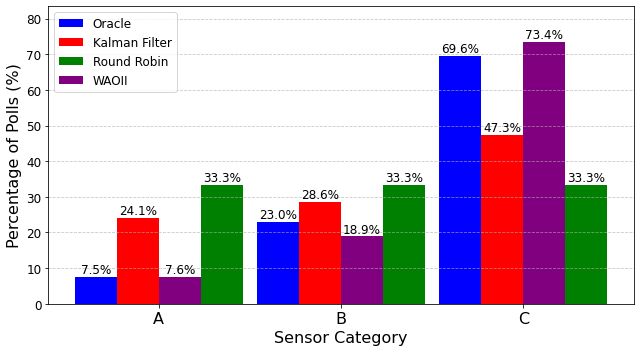

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Transmission counts
oracle_counts = [7459, 22898, 69376]
kalman_counts = [22245, 26397, 43643]
waoii_counts = [1791, 4438, 17203]

# WAOII and Round Robin are evenly distributed (33.3% each category)
waoi_round_robin_counts = [1/3, 1/3, 1/3]

# Compute total counts for each method
total_oracle = sum(oracle_counts)
total_kalman = sum(kalman_counts)
total_waoii = sum(waoii_counts)

# Convert to percentages
oracle_percentages = [count / total_oracle * 100 for count in oracle_counts]
kalman_percentages = [count / total_kalman * 100 for count in kalman_counts]
waoii_percentages = [count / total_waoii * 100 for count in waoii_counts]
waoi_round_robin_percentages = [value * 100 for value in waoi_round_robin_counts]

# Create figure for plot
plt.figure(figsize=(9, 5))

# Sensor categories
sensor_categories = ['A', 'B', 'C']
width = 0.23
x = np.arange(len(sensor_categories))

# Create bars
plt.bar(x - 1.5*width, oracle_percentages, width, label='Optimal', color='blue')
plt.bar(x - 0.5*width, kalman_percentages, width, label='KF', color='red')
plt.bar(x + 1.5*width, waoi_round_robin_percentages, width, label='Round Robin', color='green')
plt.bar(x + 0.5*width, waoii_percentages, width, label='WAOII', color='purple')

# Add percentage labels
for i, v in enumerate(oracle_percentages):
    plt.text(i - 1.5*width, v + 1, f"{v:.1f}%", ha='center', fontsize=12)
for i, v in enumerate(kalman_percentages):
    plt.text(i - 0.5*width, v + 1, f"{v:.1f}%", ha='center', fontsize=12)
for i, v in enumerate(waoii_percentages):
    plt.text(i + 0.5*width, v + 1, f"{v:.1f}%", ha='center', fontsize=12)
for i, v in enumerate(waoi_round_robin_percentages):
    plt.text(i + 1.5*width, v + 1, f"{v:.1f}%", ha='center', fontsize=12)

# Labels and formatting
plt.xlabel('Sensor Category', fontsize=16)
plt.ylabel('Percentage of Polls (%)', fontsize=16)
plt.xticks(x, sensor_categories, fontsize=16)
plt.yticks(np.arange(0, 101, 10), fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max([max(oracle_percentages), max(kalman_percentages), max(waoii_percentages), max(waoi_round_robin_percentages)]) + 10)

# Save and show plot
plt.tight_layout()
#plt.savefig("/mnt/data/activation_percentages.png", dpi=300, bbox_inches='tight')
plt.show()


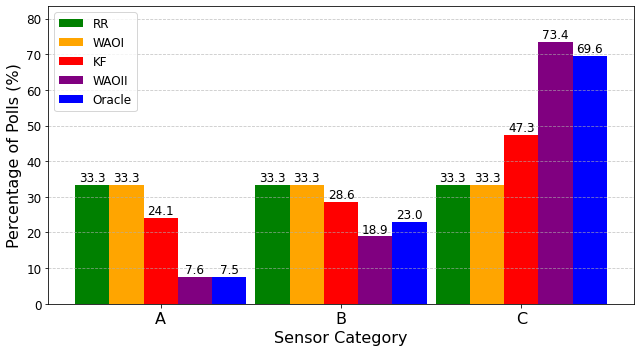

In [31]:
# Recreate the plot including WAOI with 33.3% in each category

# Transmission counts
oracle_counts = [7459, 22898, 69376]
kalman_counts = [22245, 26397, 43643]
waoii_counts = [1791, 4438, 17203]

# WAOII and Round Robin are evenly distributed (33.3% each category)
waoi_round_robin_counts = [1/3, 1/3, 1/3]
waoi_33_counts = [1/3, 1/3, 1/3]  # WAOI with 33.3% in each category

# Compute total counts for each method
total_oracle = sum(oracle_counts)
total_kalman = sum(kalman_counts)
total_waoii = sum(waoii_counts)

# Convert to percentages
oracle_percentages = [count / total_oracle * 100 for count in oracle_counts]
kalman_percentages = [count / total_kalman * 100 for count in kalman_counts]
waoii_percentages = [count / total_waoii * 100 for count in waoii_counts]
waoi_round_robin_percentages = [value * 100 for value in waoi_round_robin_counts]
waoi_33_percentages = [value * 100 for value in waoi_33_counts]

# Reorder the bars in the plot: RR, WAOI (33.3%), Kalman Filter, WAOII, Oracle

# Create figure for plot
plt.figure(figsize=(9, 5))

# Create bars in the new order
plt.bar(x - 2*width, waoi_round_robin_percentages, width, label='RR', color='green')
plt.bar(x - width, waoi_33_percentages, width, label='WAOI', color='orange')
plt.bar(x, kalman_percentages, width, label='KF', color='red')
plt.bar(x + width, waoii_percentages, width, label='WAOII', color='purple')
plt.bar(x + 2*width, oracle_percentages, width, label='Oracle', color='blue')

# Add percentage labels
for i, v in enumerate(waoi_round_robin_percentages):
    plt.text(i - 2*width, v + 1, f"{v:.1f}", ha='center', fontsize=12)
for i, v in enumerate(waoi_33_percentages):
    plt.text(i - width, v + 1, f"{v:.1f}", ha='center', fontsize=12)
for i, v in enumerate(kalman_percentages):
    plt.text(i, v + 1, f"{v:.1f}", ha='center', fontsize=12)
for i, v in enumerate(waoii_percentages):
    plt.text(i + width, v + 1, f"{v:.1f}", ha='center', fontsize=12)
for i, v in enumerate(oracle_percentages):
    plt.text(i + 2*width, v + 1, f"{v:.1f}", ha='center', fontsize=12)

# Labels and formatting
plt.xlabel('Sensor Category', fontsize=16)
plt.ylabel('Percentage of Polls (%)', fontsize=16)
plt.xticks(x, sensor_categories, fontsize=16)
plt.yticks(np.arange(0, 101, 10), fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max([max(oracle_percentages), max(kalman_percentages), max(waoii_percentages), max(waoi_round_robin_percentages), max(waoi_33_percentages)]) + 10)

# Save and show plot
plt.tight_layout()
#plt.savefig("/mnt/data/activation_percentages_reordered.png", dpi=300, bbox_inches='tight')
plt.show()
